##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 時系列予測

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルは、TensorFlow を使用した時系列予測を紹介します。畳み込みおよび回帰ニューラルネットワーク（CNN および RNN）を含む様々なスタイルのモデルを構築します。

ここでは、2 つの主要部分をサブセクションとともに説明しています。

- 単一の時間ステップの予測
    - 単一の特徴量。
    - すべての特徴量。
- 複数のステップの予測
    - シングルショット: すべての予測を一度に行います。
    - 自動回帰: 一度に 1 つの予測を行い、出力をモデルにフィードし直します。

## セットアップ

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-01-11 20:36:55.595591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 20:36:55.595635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 20:36:55.597247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 気象データセット

このチュートリアルでは、<a href="https://www.bgc-jena.mpg.de" class="external">マックス・プランク生物地球化学研究所</a>が記録した<a href="https://www.bgc-jena.mpg.de/wetter/" class="external">気象の時系列データセット</a>を使用します。

このデータセットには、気温、気圧、および湿度といった 14 個特徴量が含まれます。これらは、2003 年から 10 分ごとに収集されたデータです。効率化を図るために、2009 年から 2016 年までに収集されたデータのみを使用します。このセクションのデータセットは、「<a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>」向けに著者 François Chollet 本人によって準備されました。

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 5226496/13568290 [==========>...................] - ETA: 0s

11026432/13568290 [=======================>......] - ETA: 0s

13568290/13568290 [==============================] - 0s 0us/step


このチュートリアルでは、**時間ごとの予測**のみを使用するため、10 分間隔のデータを 1 時間間隔にサブサンプリングしましょう。

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

データをのぞいてみましょう。最初の数行は、次のようになっています。

In [5]:
df.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
5     996.50     -8.05    265.38        -8.78    94.4          3.33   
11    996.62     -8.88    264.54        -9.77    93.2          3.12   
17    996.84     -8.81    264.59        -9.66    93.5          3.13   
23    996.99     -9.05    264.34       -10.02    92.6          3.07   
29    997.46     -9.63    263.72       -10.65    92.2          2.94   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
5           3.14          0.19       1.96             3.15       1307.86   
11          2.90          0.21       1.81             2.91       1312.25   
17          2.93          0.20       1.83             2.94       1312.18   
23          2.85          0.23       1.78             2.85       1313.61   
29          2.71          0.23       1.69             2.71       1317.19   

    wv (m/s)  max. wv (m/s)  wd (deg)  
5       0.21           0.63     192.7  
11      0.25           0.63     190.3  
17      0.18           0.63     167.2  
23      0.10           0.38     240.0  
29      0.40           0.88     157.0

時が経過するにつれ、いくつかの特徴量は次のように変化しています。

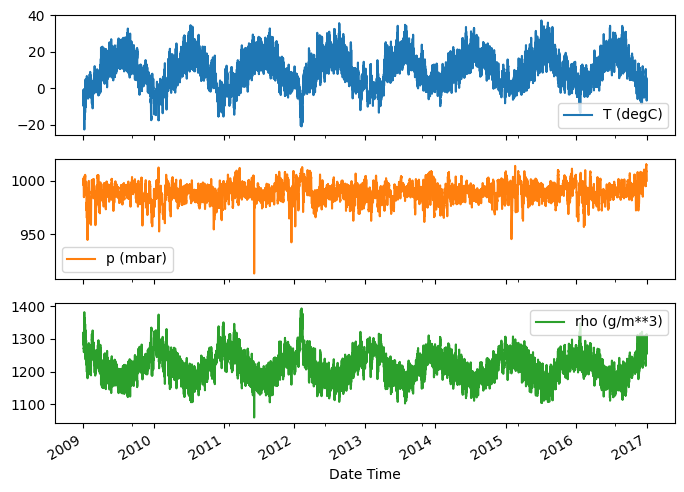

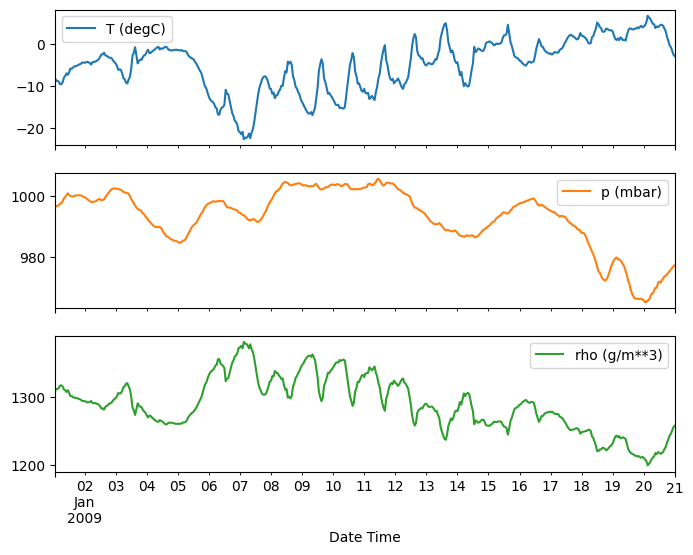

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 検査とクリーンアップ

次に、データセットの統計を確認してみましょう。

In [7]:
df.describe().transpose()

count         mean        std      min      25%      50%  \
p (mbar)         70091.0   989.212842   8.358886   913.60   984.20   989.57   
T (degC)         70091.0     9.450482   8.423384   -22.76     3.35     9.41   
Tpot (K)         70091.0   283.493086   8.504424   250.85   277.44   283.46   
Tdew (degC)      70091.0     4.956471   6.730081   -24.80     0.24     5.21   
rh (%)           70091.0    76.009788  16.474920    13.88    65.21    79.30   
VPmax (mbar)     70091.0    13.576576   7.739883     0.97     7.77    11.82   
VPact (mbar)     70091.0     9.533968   4.183658     0.81     6.22     8.86   
VPdef (mbar)     70091.0     4.042536   4.898549     0.00     0.87     2.19   
sh (g/kg)        70091.0     6.022560   2.655812     0.51     3.92     5.59   
H2OC (mmol/mol)  70091.0     9.640437   4.234862     0.81     6.29     8.96   
rho (g/m**3)     70091.0  1216.061232  39.974263  1059.45  1187.47  1213.80   
wv (m/s)         70091.0     1.702567  65.447512 -9999.00     0.99     1.76   
max. wv (m/s)    70091.0     2.963041  75.597657 -9999.00     1.76     2.98   
wd (deg)         70091.0   174.789095  86.619431     0.00   125.30   198.10   

                      75%      max  
p (mbar)          994.720  1015.29  
T (degC)           15.480    37.28  
Tpot (K)          289.530   311.21  
Tdew (degC)        10.080    23.06  
rh (%)             89.400   100.00  
VPmax (mbar)       17.610    63.77  
VPact (mbar)       12.360    28.25  
VPdef (mbar)        5.300    46.01  
sh (g/kg)           7.800    18.07  
H2OC (mmol/mol)    12.490    28.74  
rho (g/m**3)     1242.765  1393.54  
wv (m/s)            2.860    14.01  
max. wv (m/s)       4.740    23.50  
wd (deg)          234.000   360.00

#### 風速

風速の `min` 値（`wv (m/s)`）と最大値（`max. wv (m/s)`）列が目立つはずです。この `-9999` は誤りの可能性があります。

これとは別に、風向の列があるため、風速はゼロより大きい値（`>=0`）でなければなりません。これをゼロに置き換えましょう。

In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### 特徴量エンジニアリング

モデルの構築を始める前に、データを理解しておくことが重要です。また、モデルに適切にフォーマットされたデータを渡していることも確認する必要があります。

#### 風

データの最後の列にある `wd (deg)` は、角度単位の風向を示します。角度は、モデル入力には適していません。360° と 0° は互いに近く、スムーズに回り込む必要があります。風が吹いていない場合は、向きは関係ありません。

現時点では、風のデータの分布は次のようになっています。

Text(0, 0.5, 'Wind Velocity [m/s]')

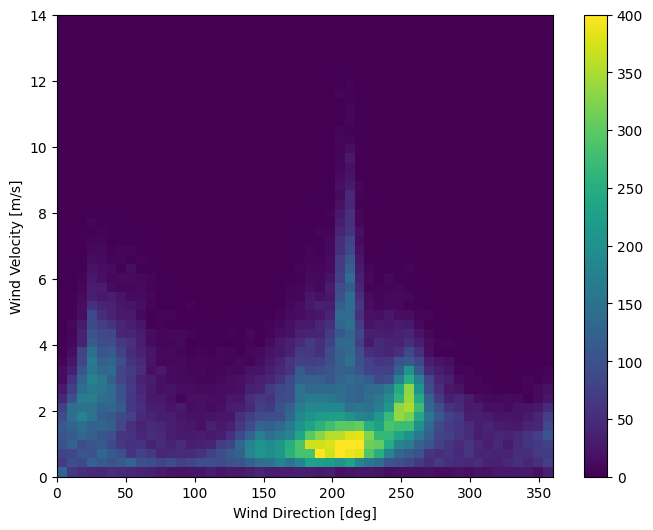

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

ただし、風向と風速の列を風の**ベクトル**に変換すると、モデルを解釈しやすくなります。

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

モデルを正しく解釈する上で、風ベクトルの分布ははるかに単純です。

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

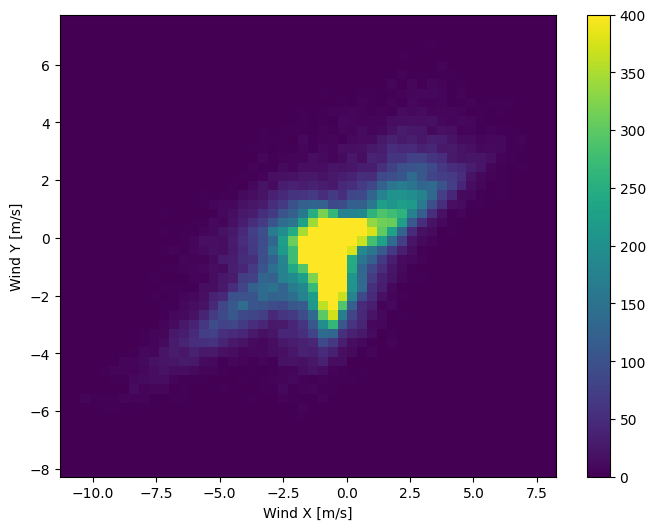

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 時刻

同様に、`Date Time` 列は非常に便利ですが、この文字列の形態ではそうでもありません。そこで、秒に変換することにします。

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

風向と同様に、秒単位の時間は、使いやすいモデル入力ではありません。気象データであるため、明確な日単位および年単位の周期性があります。周期の操作には、様々な方法があります。

使いやすい信号は、サインとコサインで明確な「Time of day（時刻）」と「Time of year（時期）」信号に変換して取得できます。

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

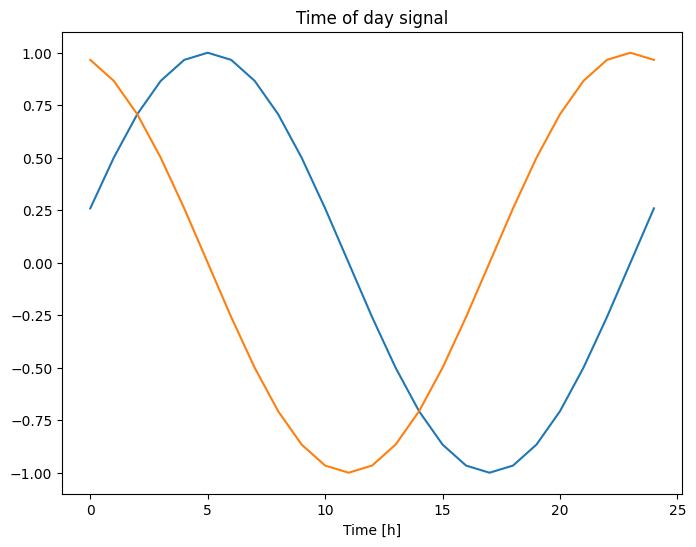

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

こうすることで、モデルはほとんどの重要な頻度特徴量にアクセスできるようになります。この場合、前もってどの頻度が重要であるかがわかっていました。

その情報がない場合は、<a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">高速フーリエ変換</a>で特徴量を抽出し、どの周波数が重要であるかを判断することができます。予想を確認するために、以下に、時間の経過に伴う気温の `tf.signal.rfft` を示します。`1/year` と `1/day` に近い周波数で明確なピークに注意してください。


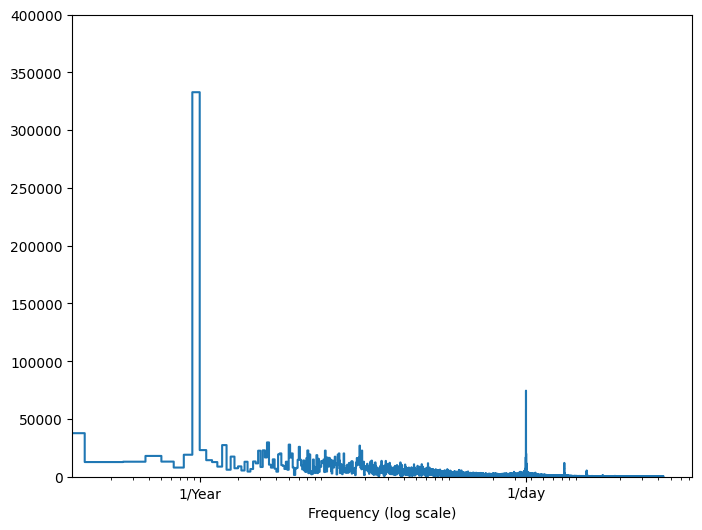

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### データを分割する

トレーニング、検証、およびテスト用のセットとして、`(70%, 20%, 10%)` に分割したものを使用します。データの分割前に、ランダムに**シャッフルされていない**ことに注意してください。これには、次の 2 つの理由があります。

1. 連続したサンプルの期間にデータが分割されていることを確実にするため。
2. 検証/テストの結果がより現実的で、モデルがトレーニングされた後に収集されたデータを評価できるようにするため。

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### データを正規化する

ニューラルネットワークをトレーニングする前に特徴量をスケーリングすることが重要です。正規化は、このスケーリングを行うための一般的な方法です。平均を減算して各特徴量の標準偏差で除算します。

平均と標準偏差は、モデルが検証とテストのセットにある値にアクセスできないように、トレーニングデータを使用してのみ計算する必要があります。

また、モデルがトレーニング中にトレーニングセットの未来の値にアクセスしないことと、この正規化が、移動する平均を使用して行われるようにすることにも論拠があります。このことは、このチュートリアルの焦点ではなく、検証とテストのセットによって、（ある程度）正直な指標が得られるようになっています。そのため、単純化するために、このチュートリアルでは、単純な平均を使用しています。

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

では、特徴量の分布をみてみましょう。いくつかの特徴量には実際にロングテールがありますが、`-9999` の風速値のような明確な誤差はありません。

/tmpfs/tmp/ipykernel_566122/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


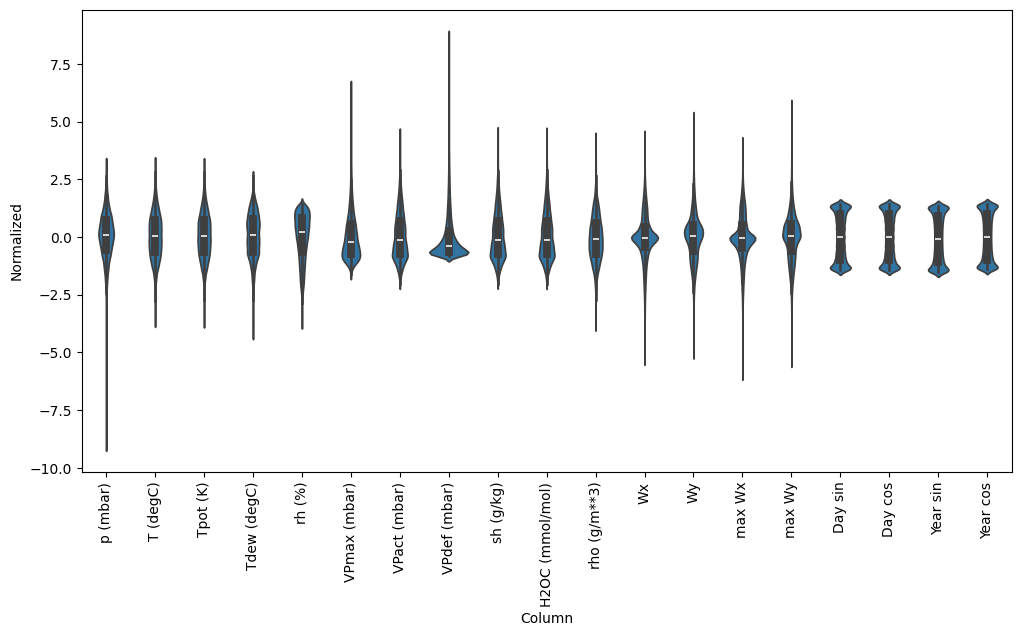

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## データのウィンドウ処理

このチュートリアルのモデルは、データの連続するサンプルのウィンドウに基づいてあるセットの予測を立てます。

入力ウィンドウの主な特徴量は次の通りです。

- 入力とラベルウィンドウの幅（時間ステップ数）
- それらの時間オフセット
- どの特徴量が入力かラベル、またはこの両方として使用されているか

このチュートリアルは、様々なモデル（線形、DNN、CNN、および RNN モデル）を構築し、次の両方に対して使用します。

- *単一出力*および*複数出力*予測。
- *単一時間ステップ*と*複数時間ステップ*予測。

このセクションでは、こういったすべてのモデルに再利用できるようにデータウィンドウ処理を実装することに焦点を当てています。


モデルのタスクと種類に応じて、様々なデータウィンドウを生成するようにするとよいでしょう。次にいくつかのサンプルを示します。

1. たとえば、24 時間先の単一予測を立てるには、過去 24 時間の履歴を指定し、次のようにウィンドウを定義することができます。

![24 時間先の予測。](images/raw_window_24h.png)

1. 1 時間先の予測を立てるモデルは、過去 6 時間の履歴を指定した場合、次のようにウィンドウを定義する必要があります。

![1 時間先の予測。](images/raw_window_1h.png)

このセクションの残りの部分では、`WindowGenerator` クラスを定義します。このクラスは、次の項目を行えます。

1. インデックスとオフセットを、上記の図に示されるように処理する。
2. 特徴量のウィンドウを `(features, labels)` ペアに分割する。
3. 結果のウィンドウのコンテンツをプロットする。
4. トレーニング、評価、およびテストデータからのこれらのウィンドウのバッチを、`tf.data.Dataset` を使用して効率的に生成する。

### 1. インデックスとオフセット

`WindowGenerator` クラスの作成から始めます。`__init__` メソッドには、入力とラベルインデックスに必要なすべての論理が含まれます。

また、トレーニング、評価、およびテストの DataFrames を入力として取ります。これらは、後でウィンドウの `tf.data.Dataset` に変換されます。

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

以下は、このセクションの始めの図に示された 2 つのウィンドウを作成するコードです。

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. 分割

リストの連続入力がある場合、`split_window` メソッドはこれらを入力のウィンドウとラベルのウィンドウに変換します。

前に定義した例の `w2` は次のように分割されます。

![初期のウィンドウはすべて連続したサンプルで、これを (inputs, labels) ペアに分割](images/split_window.png)

この図は、データの `features` 軸を表示しませんが、この `split_window` 関数は、`label_columns` も処理するため、単一出力と複数出力の例の両方に使用できます。

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

次を試します。

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


通常 TensorFlow のデータは、最も外側のインデックスがサンプル全体である配列にパックされます（「batch」次元）。中央のインデックスは、「time」または「space」（width, height）次元です。最も内側のインデックスは特徴量です。

上記のコードは、バッチ 3、7 時間ステップウィンドウ、各時間ステップに 19 個の特徴量を取りました。これを 6 時間ステップ、19 個の特徴量入力、および 1 時間ステップ 1 特徴量ラベルに分割しました。ラベルには、`WindowGenerator` が `label_columns=['T (degC)']` で初期化されたため、1 つの特徴量しかありません。最初に、このチュートリアルは単一出力ラベルを予測するモデルを構築します。

### 3. プロット

以下は、分割ウィンドウを単純に視覚化できる描画（plot）メソッドです。

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

この図は、入力、ラベル、および（後の）予測を、項目が参照する時間に基づいて整列します。

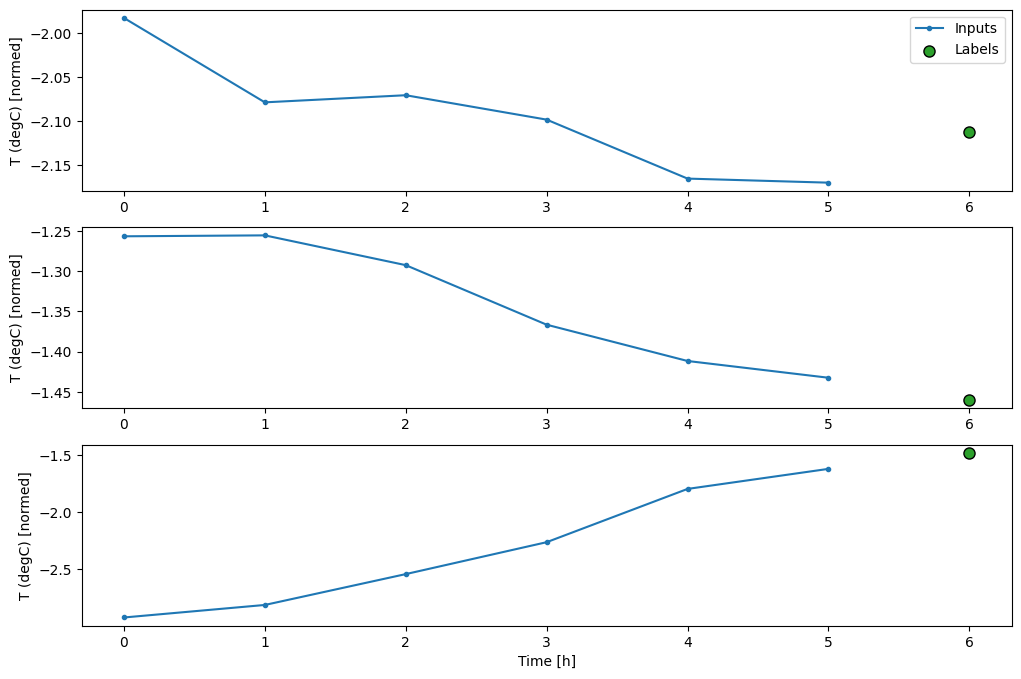

In [26]:
w2.plot()

ほかの列をプロットすることはできますが、サンプルウィンドウ `w2` 構成には、`T (degC)` 列のラベルしかありません。

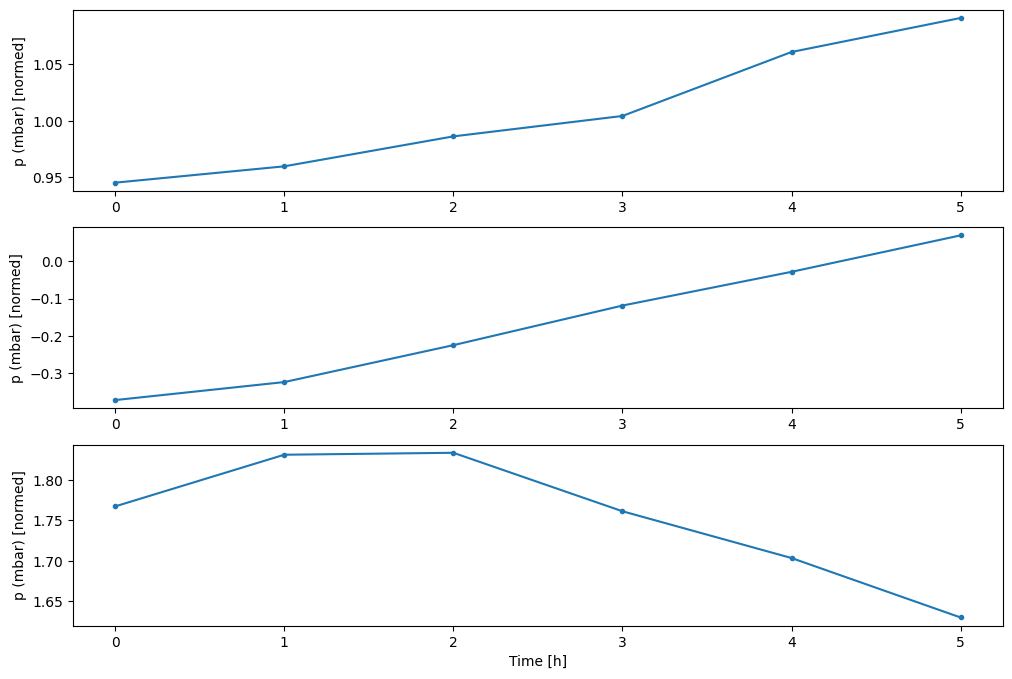

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. `tf.data.Dataset` を作成する

最後に、この `make_dataset` メソッドは時系列 DataFrame を取って、`tf.keras.utils.timeseries_dataset_from_array` 関数を使用して `(input_window, label_window)` ペアの `tf.data.Dataset` に変換します。

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` オブジェクトには、トレーニング、検証、およびテストのデータが含まれます。

これらにアクセスするためのプロパティを `tf.data.Dataset` として追加し、前に定義した`make_dataset` メソッドを使用します。また、標準のサンプルバッチを追加して、簡単にアクセスして描画できるようにします。

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

`WindowGenerator` オブジェクトにより、`tf.data.Dataset` オブジェクトにアクセスできるようになったため、データを簡単にイテレートできるようになりました。

`Dataset.element_spec` プロパティは、データセット要素の構造、データ型、および形状を示します。

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

`Dataset` をイテレートすると、具象バッチを得られます。

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## 単一ステップモデル

このようなデータで構築できる最も単純なモデルは、現在の条件のみに基づいて、1 時間ステップ（1 時間）先までの単一の特徴量の値を予測するモデルです。

そのため、1 時間先までの `T (degC)` 値を予測するモデルを構築することにします。

![次の時間ステップを予測する](images/narrow_window.png)

`WindowGenerator` オブジェクトを構成して、これらの単一ステップ `(input, label)` ペアを生成します。

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

`window` オブジェクトは、トレーニング、検証、およびテストのセットから `tf.data.Datasets` 作成し、データのバッチを簡単にイテレートできるようにします。


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### 基準

トレーニング可能なモデルを構築する前に、後のより複雑なモデルと比較するための基準ポイントとして、パフォーマンス基準を設定します。

最初のタスクは、すべての特徴量の現在の値がある場合に、1 時間先までの気温を予測することです。現在の値には、現在の気温が含まれます。

では、現在の気温のみを予測として返し、「変化なし」と予測するモデルから始めましょう。気温はゆっくりと変化するため、これは合理的な基準と言えます。もちろん、予測をずっと先まで行う場合は、この基準はあまり機能しなくなります。

![入力を出力に送信する](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

このモデルをインスタンス化して評価します。

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 4:02 - loss: 0.0198 - mean_absolute_error: 0.0958

 30/439 [=>............................] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0803  

 61/439 [===>..........................] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0792

 91/439 [=====>........................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0789

121/439 [=======>......................] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0794

150/439 [=========>....................] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0798

180/439 [===========>..................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0790

210/439 [=============>................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0788

240/439 [===============>..............] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

270/439 [=================>............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0786

300/439 [===================>..........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

330/439 [=====================>........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0786

361/439 [=======================>......] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

392/439 [=========================>....] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

423/439 [===========================>..] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


これによって何らかのパフォーマンスメトリックが出力されましたが、このモデルがどれくらいうまく機能しているかに対する感触は得られません。

`WindowGenerator` には描画メソッドがありますが、サンプルが 1 つしかないのであれば、興味深いプロットにはなりません。

そこで、24 時間連続入力とラベルのウィンドウを一度に生成するより幅の広い `WindowGenerator` を作成することにします。新しい `wide_window` 変数によってモデルの動作が変わることはありません。モデルは引き続き、1 つの入力時間ステップに基づいて 1 時間先の予測を立てます。ここでは、`time` 軸は `batch` 軸として機能します。各予測は、時間ステップ間で相互作用のない独立した予測となります。

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

コードを変更することなく、上記の拡張されたウィンドウを同じ `baseline` モデルに直接渡すことができます。これは、入力とラベルに同じ数の時間ステップがあり、基準は入力を出力に転送するだけであるため、可能です。

![1 時間先の 1 時間ごとの予測。](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


基準モデルの予測を描画すると、ラベルが 1 時間右に移動しただけであることがわかります。

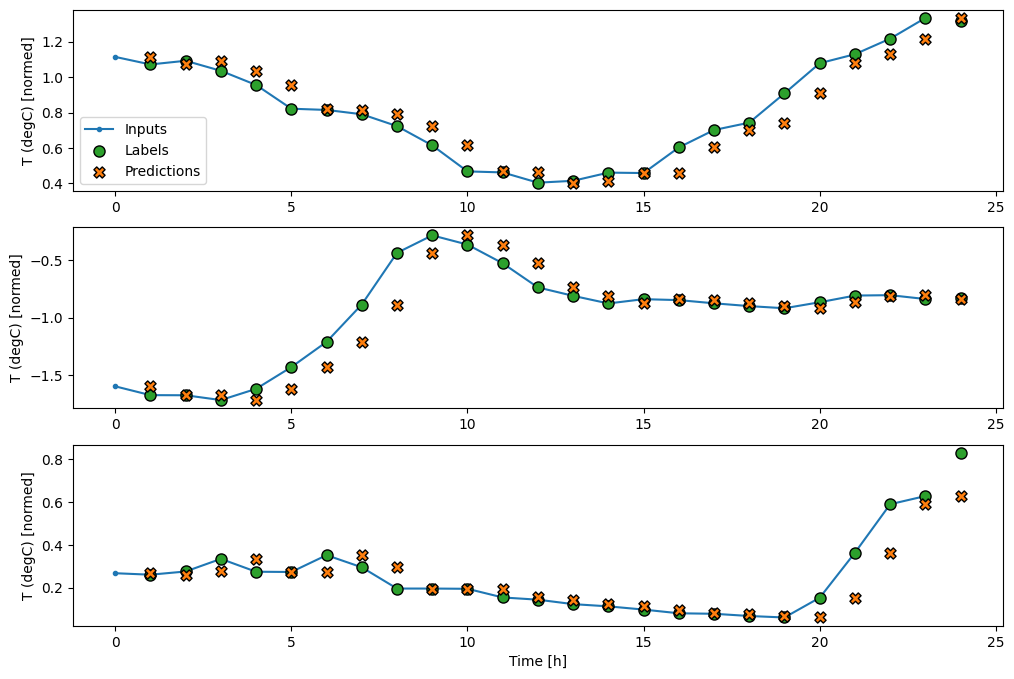

In [38]:
wide_window.plot(baseline)

上記の 3 つの例の図には、単一ステップモデルが 24 時間分実行されています。これには、次のような理由があります。

- 青い `Inputs` の線は、各時間ステップの入力気温を示します。モデルはすべての特徴量を受け取りますが、この図は気温のみを示します。
- 緑色の `Labels` の点は、ターゲットの予測値を示します。これらの点は入力時間ではなく、予測時間に示されます。そのため、ラベルの範囲は入力に対して 1 ステップ移動しています。
- オレンジ色の `Predictions` の十字は、各出力時間ステップのモデルの予測です。モデルが完璧に予測しているのであれば、予測は `Labels` に着地します。

### 線形モデル

このタスクに適用できる最も単純な**トレーニング可能な**モデルは、入力と出力間に線形変換を挿入することです。この場合、ある時間ステップの出力は、そのステップのみに依存します。

![単一ステップの予測](images/narrow_window.png)

`activation` セットのない `tf.keras.layers.Dense` レイヤーは線形モデルです。レイヤーはデータの最後の軸のみを `(batch, time, inputs)` から `(batch, time, units)` に変換するため、`batch` と `time` 軸の各項目に独立して適用されます。

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


このチュートリアルは、多くのモデルをトレーニングするため、トレーニング手順を関数にパッケージ化します。

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

モデルをトレーニングしてそのパフォーマンスを評価します。

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 17:21 - loss: 6.3810 - mean_absolute_error: 2.1376

  21/1534 [..............................] - ETA: 3s - loss: 5.2649 - mean_absolute_error: 1.8399   

I0000 00:00:1705005436.429000  566323 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  42/1534 [..............................] - ETA: 3s - loss: 4.9675 - mean_absolute_error: 1.7836

  64/1534 [>.............................] - ETA: 3s - loss: 4.7516 - mean_absolute_error: 1.7433

  85/1534 [>.............................] - ETA: 3s - loss: 4.4440 - mean_absolute_error: 1.6840

 106/1534 [=>............................] - ETA: 3s - loss: 4.1653 - mean_absolute_error: 1.6243

 127/1534 [=>............................] - ETA: 3s - loss: 3.8735 - mean_absolute_error: 1.5585

 149/1534 [=>............................] - ETA: 3s - loss: 3.6597 - mean_absolute_error: 1.5115

 171/1534 [==>...........................] - ETA: 3s - loss: 3.4349 - mean_absolute_error: 1.4589

 193/1534 [==>...........................] - ETA: 3s - loss: 3.2319 - mean_absolute_error: 1.4117

 213/1534 [===>..........................] - ETA: 3s - loss: 3.0590 - mean_absolute_error: 1.3672

 235/1534 [===>..........................] - ETA: 3s - loss: 2.8875 - mean_absolute_error: 1.3233

 257/1534 [====>.........................] - ETA: 3s - loss: 2.7239 - mean_absolute_error: 1.2789

 279/1534 [====>.........................] - ETA: 3s - loss: 2.5966 - mean_absolute_error: 1.2446

 301/1534 [====>.........................] - ETA: 2s - loss: 2.4767 - mean_absolute_error: 1.2124

 323/1534 [=====>........................] - ETA: 2s - loss: 2.3678 - mean_absolute_error: 1.1817

 345/1534 [=====>........................] - ETA: 2s - loss: 2.2650 - mean_absolute_error: 1.1513

 366/1534 [======>.......................] - ETA: 2s - loss: 2.1764 - mean_absolute_error: 1.1249

 387/1534 [======>.......................] - ETA: 2s - loss: 2.0909 - mean_absolute_error: 1.0985

 409/1534 [======>.......................] - ETA: 2s - loss: 2.0103 - mean_absolute_error: 1.0731

 433/1534 [=======>......................] - ETA: 2s - loss: 1.9298 - mean_absolute_error: 1.0471

 454/1534 [=======>......................] - ETA: 2s - loss: 1.8641 - mean_absolute_error: 1.0253

 475/1534 [========>.....................] - ETA: 2s - loss: 1.8019 - mean_absolute_error: 1.0040

 497/1534 [========>.....................] - ETA: 2s - loss: 1.7404 - mean_absolute_error: 0.9827

 518/1534 [=========>....................] - ETA: 2s - loss: 1.6856 - mean_absolute_error: 0.9631

 540/1534 [=========>....................] - ETA: 2s - loss: 1.6305 - mean_absolute_error: 0.9430

 562/1534 [=========>....................] - ETA: 2s - loss: 1.5809 - mean_absolute_error: 0.9252

 583/1534 [==========>...................] - ETA: 2s - loss: 1.5334 - mean_absolute_error: 0.9065

 604/1534 [==========>...................] - ETA: 2s - loss: 1.4887 - mean_absolute_error: 0.8891

 625/1534 [===========>..................] - ETA: 2s - loss: 1.4464 - mean_absolute_error: 0.8722

 647/1534 [===========>..................] - ETA: 2s - loss: 1.4052 - mean_absolute_error: 0.8559

 668/1534 [============>.................] - ETA: 2s - loss: 1.3676 - mean_absolute_error: 0.8406

 690/1534 [============>.................] - ETA: 2s - loss: 1.3305 - mean_absolute_error: 0.8254

 712/1534 [============>.................] - ETA: 1s - loss: 1.2949 - mean_absolute_error: 0.8104

 733/1534 [=============>................] - ETA: 1s - loss: 1.2628 - mean_absolute_error: 0.7968

 755/1534 [=============>................] - ETA: 1s - loss: 1.2304 - mean_absolute_error: 0.7828

 776/1534 [==============>...............] - ETA: 1s - loss: 1.2012 - mean_absolute_error: 0.7699

 797/1534 [==============>...............] - ETA: 1s - loss: 1.1730 - mean_absolute_error: 0.7572

 818/1534 [==============>...............] - ETA: 1s - loss: 1.1463 - mean_absolute_error: 0.7452

 840/1534 [===============>..............] - ETA: 1s - loss: 1.1195 - mean_absolute_error: 0.7330

 862/1534 [===============>..............] - ETA: 1s - loss: 1.0939 - mean_absolute_error: 0.7211

 884/1534 [================>.............] - ETA: 1s - loss: 1.0693 - mean_absolute_error: 0.7096

 906/1534 [================>.............] - ETA: 1s - loss: 1.0456 - mean_absolute_error: 0.6982

 927/1534 [=================>............] - ETA: 1s - loss: 1.0240 - mean_absolute_error: 0.6877

 948/1534 [=================>............] - ETA: 1s - loss: 1.0034 - mean_absolute_error: 0.6778

 969/1534 [=================>............] - ETA: 1s - loss: 0.9836 - mean_absolute_error: 0.6681

 990/1534 [==================>...........] - ETA: 1s - loss: 0.9645 - mean_absolute_error: 0.6587

1011/1534 [==================>...........] - ETA: 1s - loss: 0.9460 - mean_absolute_error: 0.6495

1032/1534 [===================>..........] - ETA: 1s - loss: 0.9283 - mean_absolute_error: 0.6407

1052/1534 [===================>..........] - ETA: 1s - loss: 0.9120 - mean_absolute_error: 0.6324

1073/1534 [===================>..........] - ETA: 1s - loss: 0.8954 - mean_absolute_error: 0.6239

1095/1534 [====================>.........] - ETA: 1s - loss: 0.8786 - mean_absolute_error: 0.6152

1117/1534 [====================>.........] - ETA: 0s - loss: 0.8625 - mean_absolute_error: 0.6068

1138/1534 [=====================>........] - ETA: 0s - loss: 0.8477 - mean_absolute_error: 0.5991

1160/1534 [=====================>........] - ETA: 0s - loss: 0.8327 - mean_absolute_error: 0.5912

1181/1534 [======================>.......] - ETA: 0s - loss: 0.8188 - mean_absolute_error: 0.5838

1202/1534 [======================>.......] - ETA: 0s - loss: 0.8056 - mean_absolute_error: 0.5768

1223/1534 [======================>.......] - ETA: 0s - loss: 0.7926 - mean_absolute_error: 0.5699

1244/1534 [=======================>......] - ETA: 0s - loss: 0.7801 - mean_absolute_error: 0.5632

1265/1534 [=======================>......] - ETA: 0s - loss: 0.7679 - mean_absolute_error: 0.5567

1286/1534 [========================>.....] - ETA: 0s - loss: 0.7561 - mean_absolute_error: 0.5503

1308/1534 [========================>.....] - ETA: 0s - loss: 0.7443 - mean_absolute_error: 0.5439

1329/1534 [========================>.....] - ETA: 0s - loss: 0.7333 - mean_absolute_error: 0.5379

1350/1534 [=========================>....] - ETA: 0s - loss: 0.7227 - mean_absolute_error: 0.5323

1371/1534 [=========================>....] - ETA: 0s - loss: 0.7123 - mean_absolute_error: 0.5266

1393/1534 [==========================>...] - ETA: 0s - loss: 0.7018 - mean_absolute_error: 0.5208

1414/1534 [==========================>...] - ETA: 0s - loss: 0.6920 - mean_absolute_error: 0.5155

1435/1534 [===========================>..] - ETA: 0s - loss: 0.6825 - mean_absolute_error: 0.5103

1456/1534 [===========================>..] - ETA: 0s - loss: 0.6733 - mean_absolute_error: 0.5051

1477/1534 [===========================>..] - ETA: 0s - loss: 0.6643 - mean_absolute_error: 0.5003

1498/1534 [============================>.] - ETA: 0s - loss: 0.6555 - mean_absolute_error: 0.4952

1520/1534 [============================>.] - ETA: 0s - loss: 0.6466 - mean_absolute_error: 0.4902

1534/1534 [==============================] - 5s 3ms/step - loss: 0.6413 - mean_absolute_error: 0.4871 - val_loss: 0.0313 - val_mean_absolute_error: 0.1402


Epoch 2/20


   1/1534 [..............................] - ETA: 1:00 - loss: 0.0268 - mean_absolute_error: 0.1296

  22/1534 [..............................] - ETA: 3s - loss: 0.0314 - mean_absolute_error: 0.1341  

  43/1534 [..............................] - ETA: 3s - loss: 0.0348 - mean_absolute_error: 0.1407

  65/1534 [>.............................] - ETA: 3s - loss: 0.0349 - mean_absolute_error: 0.1414

  86/1534 [>.............................] - ETA: 3s - loss: 0.0360 - mean_absolute_error: 0.1431

 108/1534 [=>............................] - ETA: 3s - loss: 0.0351 - mean_absolute_error: 0.1422

 130/1534 [=>............................] - ETA: 3s - loss: 0.0349 - mean_absolute_error: 0.1420

 152/1534 [=>............................] - ETA: 3s - loss: 0.0344 - mean_absolute_error: 0.1406

 174/1534 [==>...........................] - ETA: 3s - loss: 0.0338 - mean_absolute_error: 0.1394

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0331 - mean_absolute_error: 0.1379

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0329 - mean_absolute_error: 0.1374

 240/1534 [===>..........................] - ETA: 3s - loss: 0.0328 - mean_absolute_error: 0.1373

 262/1534 [====>.........................] - ETA: 2s - loss: 0.0324 - mean_absolute_error: 0.1366

 285/1534 [====>.........................] - ETA: 2s - loss: 0.0320 - mean_absolute_error: 0.1357

 306/1534 [====>.........................] - ETA: 2s - loss: 0.0319 - mean_absolute_error: 0.1353

 328/1534 [=====>........................] - ETA: 2s - loss: 0.0316 - mean_absolute_error: 0.1346

 350/1534 [=====>........................] - ETA: 2s - loss: 0.0312 - mean_absolute_error: 0.1340

 371/1534 [======>.......................] - ETA: 2s - loss: 0.0309 - mean_absolute_error: 0.1331

 392/1534 [======>.......................] - ETA: 2s - loss: 0.0306 - mean_absolute_error: 0.1325

 413/1534 [=======>......................] - ETA: 2s - loss: 0.0304 - mean_absolute_error: 0.1319

 435/1534 [=======>......................] - ETA: 2s - loss: 0.0301 - mean_absolute_error: 0.1312

 457/1534 [=======>......................] - ETA: 2s - loss: 0.0297 - mean_absolute_error: 0.1302

 478/1534 [========>.....................] - ETA: 2s - loss: 0.0294 - mean_absolute_error: 0.1296

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0293 - mean_absolute_error: 0.1291

 520/1534 [=========>....................] - ETA: 2s - loss: 0.0289 - mean_absolute_error: 0.1282

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0288 - mean_absolute_error: 0.1278

 563/1534 [==========>...................] - ETA: 2s - loss: 0.0287 - mean_absolute_error: 0.1275

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0283 - mean_absolute_error: 0.1267

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0281 - mean_absolute_error: 0.1261

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0279 - mean_absolute_error: 0.1255

 651/1534 [===========>..................] - ETA: 2s - loss: 0.0276 - mean_absolute_error: 0.1250

 673/1534 [============>.................] - ETA: 2s - loss: 0.0275 - mean_absolute_error: 0.1246

 695/1534 [============>.................] - ETA: 1s - loss: 0.0273 - mean_absolute_error: 0.1240

 717/1534 [=============>................] - ETA: 1s - loss: 0.0270 - mean_absolute_error: 0.1234

 738/1534 [=============>................] - ETA: 1s - loss: 0.0268 - mean_absolute_error: 0.1227

 760/1534 [=============>................] - ETA: 1s - loss: 0.0265 - mean_absolute_error: 0.1222

 781/1534 [==============>...............] - ETA: 1s - loss: 0.0264 - mean_absolute_error: 0.1219

 802/1534 [==============>...............] - ETA: 1s - loss: 0.0263 - mean_absolute_error: 0.1214

 823/1534 [===============>..............] - ETA: 1s - loss: 0.0261 - mean_absolute_error: 0.1211

 845/1534 [===============>..............] - ETA: 1s - loss: 0.0260 - mean_absolute_error: 0.1206

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0258 - mean_absolute_error: 0.1202

 889/1534 [================>.............] - ETA: 1s - loss: 0.0256 - mean_absolute_error: 0.1198

 911/1534 [================>.............] - ETA: 1s - loss: 0.0254 - mean_absolute_error: 0.1193

 933/1534 [=================>............] - ETA: 1s - loss: 0.0253 - mean_absolute_error: 0.1188

 955/1534 [=================>............] - ETA: 1s - loss: 0.0251 - mean_absolute_error: 0.1184

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0249 - mean_absolute_error: 0.1180

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0247 - mean_absolute_error: 0.1175

1020/1534 [==================>...........] - ETA: 1s - loss: 0.0246 - mean_absolute_error: 0.1171

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0245 - mean_absolute_error: 0.1167

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0243 - mean_absolute_error: 0.1162

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0241 - mean_absolute_error: 0.1158

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0240 - mean_absolute_error: 0.1153

1130/1534 [=====================>........] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.1148

1152/1534 [=====================>........] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.1143

1174/1534 [=====================>........] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.1140

1196/1534 [======================>.......] - ETA: 0s - loss: 0.0234 - mean_absolute_error: 0.1137

1218/1534 [======================>.......] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.1132

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.1127

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0229 - mean_absolute_error: 0.1124

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0228 - mean_absolute_error: 0.1120

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.1116

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0225 - mean_absolute_error: 0.1112

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.1109

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.1105

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.1102

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.1099

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0220 - mean_absolute_error: 0.1096

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.1093

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.1090

1494/1534 [============================>.] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.1086

1515/1534 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.1083

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0214 - mean_absolute_error: 0.1080 - val_loss: 0.0116 - val_mean_absolute_error: 0.0802


Epoch 3/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0102 - mean_absolute_error: 0.0763

  21/1534 [..............................] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0786 

  42/1534 [..............................] - ETA: 3s - loss: 0.0121 - mean_absolute_error: 0.0818

  63/1534 [>.............................] - ETA: 3s - loss: 0.0126 - mean_absolute_error: 0.0833

  85/1534 [>.............................] - ETA: 3s - loss: 0.0130 - mean_absolute_error: 0.0846

 107/1534 [=>............................] - ETA: 3s - loss: 0.0128 - mean_absolute_error: 0.0840

 128/1534 [=>............................] - ETA: 3s - loss: 0.0125 - mean_absolute_error: 0.0832

 150/1534 [=>............................] - ETA: 3s - loss: 0.0124 - mean_absolute_error: 0.0830

 172/1534 [==>...........................] - ETA: 3s - loss: 0.0122 - mean_absolute_error: 0.0821

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0119 - mean_absolute_error: 0.0813

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0119 - mean_absolute_error: 0.0814

 235/1534 [===>..........................] - ETA: 3s - loss: 0.0120 - mean_absolute_error: 0.0815

 257/1534 [====>.........................] - ETA: 3s - loss: 0.0119 - mean_absolute_error: 0.0814

 280/1534 [====>.........................] - ETA: 2s - loss: 0.0118 - mean_absolute_error: 0.0809

 302/1534 [====>.........................] - ETA: 2s - loss: 0.0117 - mean_absolute_error: 0.0809

 324/1534 [=====>........................] - ETA: 2s - loss: 0.0116 - mean_absolute_error: 0.0806

 345/1534 [=====>........................] - ETA: 2s - loss: 0.0117 - mean_absolute_error: 0.0806

 367/1534 [======>.......................] - ETA: 2s - loss: 0.0117 - mean_absolute_error: 0.0806

 388/1534 [======>.......................] - ETA: 2s - loss: 0.0117 - mean_absolute_error: 0.0803

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0117 - mean_absolute_error: 0.0801

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0116 - mean_absolute_error: 0.0800

 454/1534 [=======>......................] - ETA: 2s - loss: 0.0116 - mean_absolute_error: 0.0800

 476/1534 [========>.....................] - ETA: 2s - loss: 0.0115 - mean_absolute_error: 0.0796

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0115 - mean_absolute_error: 0.0796

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0115 - mean_absolute_error: 0.0796

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0115 - mean_absolute_error: 0.0795

 561/1534 [=========>....................] - ETA: 2s - loss: 0.0116 - mean_absolute_error: 0.0795

 582/1534 [==========>...................] - ETA: 2s - loss: 0.0115 - mean_absolute_error: 0.0793

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0115 - mean_absolute_error: 0.0791

 624/1534 [===========>..................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0790

 645/1534 [===========>..................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0788

 666/1534 [============>.................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0788

 687/1534 [============>.................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0786

 708/1534 [============>.................] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0784

 729/1534 [=============>................] - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.0781

 751/1534 [=============>................] - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.0780

 773/1534 [==============>...............] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0779

 795/1534 [==============>...............] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0778

 817/1534 [==============>...............] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0776

 839/1534 [===============>..............] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0777

 860/1534 [===============>..............] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0776

 882/1534 [================>.............] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0776

 904/1534 [================>.............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0774

 926/1534 [=================>............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0773

 947/1534 [=================>............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0772

 968/1534 [=================>............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0771

 989/1534 [==================>...........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0770

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0769

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0768

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0768

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0768

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0766

1116/1534 [====================>.........] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0765

1138/1534 [=====================>........] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0764

1160/1534 [=====================>........] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0765

1182/1534 [======================>.......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0764

1204/1534 [======================>.......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0764

1226/1534 [======================>.......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0763

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0761

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0760

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0759

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0759

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0759

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0758

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0757

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0758

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0757

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0757

1485/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0756

1506/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0755

1527/1534 [============================>.] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0755

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0105 - mean_absolute_error: 0.0755 - val_loss: 0.0091 - val_mean_absolute_error: 0.0703


Epoch 4/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0125 - mean_absolute_error: 0.0731

  20/1534 [..............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696 

  41/1534 [..............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0708

  62/1534 [>.............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0732

  83/1534 [>.............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0732

 104/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0725

 125/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0723

 146/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0722

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0716

 188/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0710

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0710

 231/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0711

 253/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0711

 276/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0710

 298/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0710

 319/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0708

 340/1534 [=====>........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0710

 361/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0711

 382/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0709

 403/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0709

 424/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 445/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0709

 466/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 488/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0706

 510/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 532/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 598/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 620/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 685/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 707/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 729/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 751/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 772/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 793/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 837/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 859/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 880/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 902/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 924/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 946/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 967/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 989/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1120/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1141/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1162/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1183/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1204/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1226/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1485/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1507/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1530/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0702 - val_loss: 0.0087 - val_mean_absolute_error: 0.0687


Epoch 5/20


   1/1534 [..............................] - ETA: 1:00 - loss: 0.0103 - mean_absolute_error: 0.0711

  22/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0682  

  43/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0692

  64/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0721

  86/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0722

 108/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0714

 129/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 150/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0710

 171/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0707

 192/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0701

 213/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0702

 235/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0701

 257/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0700

 280/1534 [====>.........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0699

 301/1534 [====>.........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0701

 323/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 345/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 367/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 389/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 474/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 495/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 582/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 669/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 691/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 713/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 734/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 755/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 776/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 797/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 818/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 839/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 861/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 883/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 904/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 925/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 946/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 967/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1117/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1138/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1159/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1181/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1202/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1224/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1486/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1508/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1530/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0689


Epoch 6/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0103 - mean_absolute_error: 0.0727

  22/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0677 

  44/1534 [..............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

  66/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0714

  88/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0719

 110/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0715

 132/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0712

 153/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 175/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0707

 197/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0702

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0701

 240/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0704

 263/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 286/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 307/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 329/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 351/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0703

 372/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0703

 393/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 415/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 436/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 457/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 586/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 608/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 674/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 696/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 718/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 740/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 762/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 783/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 804/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 824/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 845/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 866/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 888/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 910/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 931/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 953/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1128/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1150/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1171/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1214/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1490/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1511/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1532/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0684


Epoch 7/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0062 - mean_absolute_error: 0.0573

  21/1534 [..............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694 

  43/1534 [..............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0701

  64/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0717

  85/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0722

 107/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0715

 129/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0710

 151/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0709

 172/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0708

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0703

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0702

 236/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0705

 258/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0704

 282/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 303/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 325/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 346/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 367/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 388/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 475/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 496/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 581/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 602/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 622/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 685/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 706/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 727/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 749/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 793/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 837/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 858/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 879/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 900/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 921/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 943/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 964/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1117/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1139/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1161/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1183/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1205/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1248/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1487/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1508/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1531/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0087 - val_mean_absolute_error: 0.0687


Epoch 8/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0081 - mean_absolute_error: 0.0683

  22/1534 [..............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0689 

  43/1534 [..............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

  64/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0713

  85/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0718

 105/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0712

 125/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0708

 145/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0713

 165/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0709

 185/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0706

 206/1534 [===>..........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0702

 227/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0702

 248/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0703

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0700

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0702

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0701

 332/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0700

 352/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 373/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 395/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 416/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 522/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 566/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 588/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 674/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 696/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 718/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 740/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 762/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 784/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 805/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 827/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 849/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 871/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 892/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 914/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 935/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 956/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1130/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1151/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1194/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1494/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1516/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0087 - val_mean_absolute_error: 0.0686


  1/439 [..............................] - ETA: 37s - loss: 0.0096 - mean_absolute_error: 0.0698

 26/439 [>.............................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0682 

 53/439 [==>...........................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0693

 81/439 [====>.........................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0693

108/439 [======>.......................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0688

134/439 [========>.....................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0684

160/439 [=========>....................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0684

186/439 [===========>..................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0682

212/439 [=============>................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0681

238/439 [===============>..............] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0681

263/439 [================>.............] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0682

289/439 [==================>...........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0685

316/439 [====================>.........] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0687

343/439 [======================>.......] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0686

370/439 [========================>.....] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0686

397/439 [==========================>...] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0685

424/439 [===========================>..] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0683

439/439 [==============================] - 1s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0686


`baseline` モデルと同様に、線形モデルは、ワイドウィンドウのバッチで呼び出すことができます。このように使用することで、モデルは連続した時間ステップに対して独立した一連の予測を立てます。`time` 軸は、別の `batch` 軸のように機能します。各時間ステップの予測間に相互作用はありません。

![単一ステップの予測](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


次は、`wide_widow` に対するサンプル予測の図です。多くの場合、入力気温のみを返すよりも予測が明らかに優れているのがわかりますが、いくつかのケースでは悪化しています。

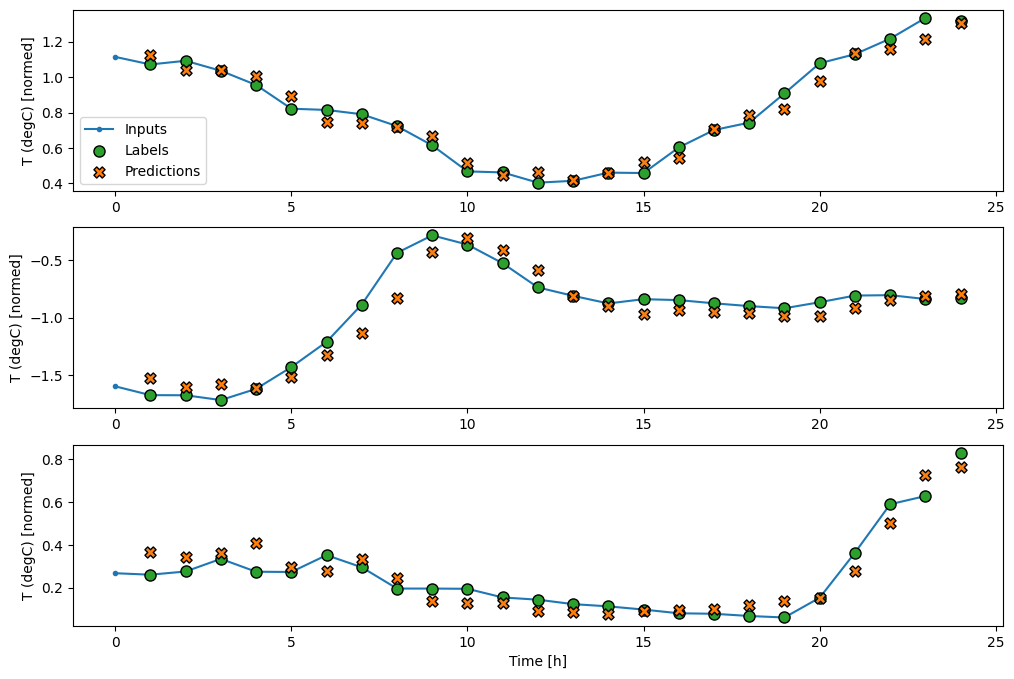

In [44]:
wide_window.plot(linear)

線形モデルには、比較的解釈しやすいというメリットがあります。レイヤーの重みを引き出して、各入力に割り当てられた重みを確認することができます。

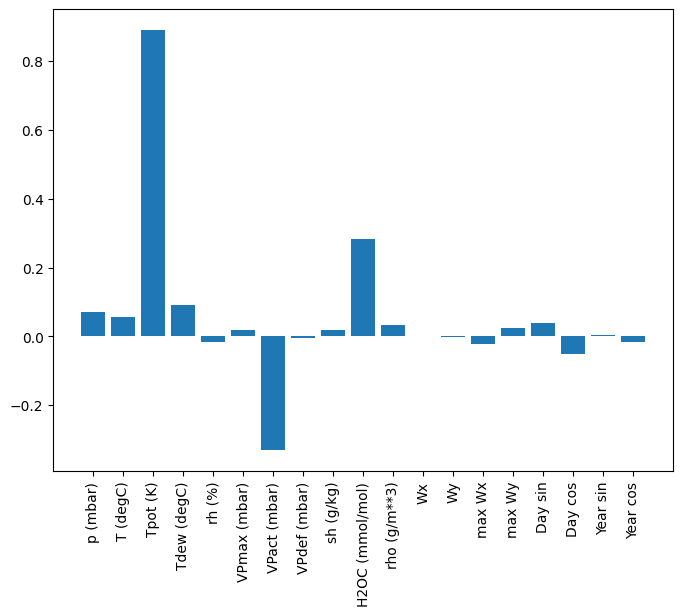

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

場合によっては、モデルには、入力 `T (degC)` のほとんどの重みを配置しないこともあります。これが、ランダム初期化のリスクの 1 つです。 

### Dense

複数の時間ステップで実際に動作するモデルを適用する前に、より深く強力な単一入力ステップモデルのパフォーマンスを確認しておく価値があります。

次は、`linear` モデルに似たモデルですが、入力と出力の間にいくつかの `Dense` レイヤーがスタックされています。 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 32:51 - loss: 1.4916 - mean_absolute_error: 0.9511

  16/1534 [..............................] - ETA: 5s - loss: 0.3978 - mean_absolute_error: 0.4270   

  32/1534 [..............................] - ETA: 5s - loss: 0.2345 - mean_absolute_error: 0.3181

  48/1534 [..............................] - ETA: 4s - loss: 0.1674 - mean_absolute_error: 0.2591

  64/1534 [>.............................] - ETA: 4s - loss: 0.1310 - mean_absolute_error: 0.2227

  80/1534 [>.............................] - ETA: 4s - loss: 0.1086 - mean_absolute_error: 0.1994

  96/1534 [>.............................] - ETA: 4s - loss: 0.0933 - mean_absolute_error: 0.1831

 112/1534 [=>............................] - ETA: 4s - loss: 0.0820 - mean_absolute_error: 0.1700

 128/1534 [=>............................] - ETA: 4s - loss: 0.0735 - mean_absolute_error: 0.1603

 144/1534 [=>............................] - ETA: 4s - loss: 0.0667 - mean_absolute_error: 0.1519

 160/1534 [==>...........................] - ETA: 4s - loss: 0.0616 - mean_absolute_error: 0.1462

 176/1534 [==>...........................] - ETA: 4s - loss: 0.0570 - mean_absolute_error: 0.1403

 192/1534 [==>...........................] - ETA: 4s - loss: 0.0534 - mean_absolute_error: 0.1359

 209/1534 [===>..........................] - ETA: 4s - loss: 0.0501 - mean_absolute_error: 0.1317

 225/1534 [===>..........................] - ETA: 4s - loss: 0.0474 - mean_absolute_error: 0.1283

 241/1534 [===>..........................] - ETA: 4s - loss: 0.0451 - mean_absolute_error: 0.1254

 257/1534 [====>.........................] - ETA: 4s - loss: 0.0430 - mean_absolute_error: 0.1227

 273/1534 [====>.........................] - ETA: 4s - loss: 0.0411 - mean_absolute_error: 0.1201

 290/1534 [====>.........................] - ETA: 4s - loss: 0.0393 - mean_absolute_error: 0.1176

 306/1534 [====>.........................] - ETA: 3s - loss: 0.0378 - mean_absolute_error: 0.1156

 322/1534 [=====>........................] - ETA: 3s - loss: 0.0364 - mean_absolute_error: 0.1136

 338/1534 [=====>........................] - ETA: 3s - loss: 0.0352 - mean_absolute_error: 0.1120

 354/1534 [=====>........................] - ETA: 3s - loss: 0.0340 - mean_absolute_error: 0.1101

 370/1534 [======>.......................] - ETA: 3s - loss: 0.0330 - mean_absolute_error: 0.1087

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0321 - mean_absolute_error: 0.1076

 402/1534 [======>.......................] - ETA: 3s - loss: 0.0313 - mean_absolute_error: 0.1064

 418/1534 [=======>......................] - ETA: 3s - loss: 0.0305 - mean_absolute_error: 0.1052

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0298 - mean_absolute_error: 0.1041

 450/1534 [=======>......................] - ETA: 3s - loss: 0.0291 - mean_absolute_error: 0.1030

 466/1534 [========>.....................] - ETA: 3s - loss: 0.0284 - mean_absolute_error: 0.1020

 483/1534 [========>.....................] - ETA: 3s - loss: 0.0277 - mean_absolute_error: 0.1008

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0271 - mean_absolute_error: 0.0999

 515/1534 [=========>....................] - ETA: 3s - loss: 0.0265 - mean_absolute_error: 0.0990

 531/1534 [=========>....................] - ETA: 3s - loss: 0.0260 - mean_absolute_error: 0.0983

 547/1534 [=========>....................] - ETA: 3s - loss: 0.0255 - mean_absolute_error: 0.0975

 563/1534 [==========>...................] - ETA: 3s - loss: 0.0251 - mean_absolute_error: 0.0969

 579/1534 [==========>...................] - ETA: 3s - loss: 0.0247 - mean_absolute_error: 0.0962

 595/1534 [==========>...................] - ETA: 3s - loss: 0.0243 - mean_absolute_error: 0.0957

 611/1534 [==========>...................] - ETA: 2s - loss: 0.0239 - mean_absolute_error: 0.0950

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0235 - mean_absolute_error: 0.0943

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0231 - mean_absolute_error: 0.0937

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0228 - mean_absolute_error: 0.0932

 675/1534 [============>.................] - ETA: 2s - loss: 0.0225 - mean_absolute_error: 0.0928

 691/1534 [============>.................] - ETA: 2s - loss: 0.0222 - mean_absolute_error: 0.0923

 707/1534 [============>.................] - ETA: 2s - loss: 0.0219 - mean_absolute_error: 0.0918

 723/1534 [=============>................] - ETA: 2s - loss: 0.0216 - mean_absolute_error: 0.0913

 739/1534 [=============>................] - ETA: 2s - loss: 0.0213 - mean_absolute_error: 0.0908

 755/1534 [=============>................] - ETA: 2s - loss: 0.0211 - mean_absolute_error: 0.0906

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0209 - mean_absolute_error: 0.0902

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0206 - mean_absolute_error: 0.0898

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0204 - mean_absolute_error: 0.0895

 819/1534 [===============>..............] - ETA: 2s - loss: 0.0202 - mean_absolute_error: 0.0892

 835/1534 [===============>..............] - ETA: 2s - loss: 0.0200 - mean_absolute_error: 0.0887

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0198 - mean_absolute_error: 0.0884

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0196 - mean_absolute_error: 0.0880

 883/1534 [================>.............] - ETA: 2s - loss: 0.0194 - mean_absolute_error: 0.0878

 899/1534 [================>.............] - ETA: 2s - loss: 0.0192 - mean_absolute_error: 0.0874

 915/1534 [================>.............] - ETA: 1s - loss: 0.0190 - mean_absolute_error: 0.0870

 931/1534 [=================>............] - ETA: 1s - loss: 0.0188 - mean_absolute_error: 0.0867

 947/1534 [=================>............] - ETA: 1s - loss: 0.0186 - mean_absolute_error: 0.0863

 963/1534 [=================>............] - ETA: 1s - loss: 0.0185 - mean_absolute_error: 0.0860

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0183 - mean_absolute_error: 0.0858

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0182 - mean_absolute_error: 0.0856

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0181 - mean_absolute_error: 0.0854

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0179 - mean_absolute_error: 0.0852

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0178 - mean_absolute_error: 0.0848

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0176 - mean_absolute_error: 0.0846

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0175 - mean_absolute_error: 0.0843

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0174 - mean_absolute_error: 0.0840

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0172 - mean_absolute_error: 0.0838

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0171 - mean_absolute_error: 0.0837

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0170 - mean_absolute_error: 0.0835

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0169 - mean_absolute_error: 0.0833

1168/1534 [=====================>........] - ETA: 1s - loss: 0.0168 - mean_absolute_error: 0.0831

1184/1534 [======================>.......] - ETA: 1s - loss: 0.0167 - mean_absolute_error: 0.0829

1200/1534 [======================>.......] - ETA: 1s - loss: 0.0166 - mean_absolute_error: 0.0827

1216/1534 [======================>.......] - ETA: 1s - loss: 0.0165 - mean_absolute_error: 0.0825

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0822

1248/1534 [=======================>......] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0819

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.0817

1280/1534 [========================>.....] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.0816

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0814

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0812

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0811

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0810

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0808

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0806

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0805

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.0803

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0801

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0800

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0798

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0797

1488/1534 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0796

1504/1534 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0795

1520/1534 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0793

1534/1534 [==============================] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0793

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0148 - mean_absolute_error: 0.0793 - val_loss: 0.0087 - val_mean_absolute_error: 0.0685


Epoch 2/20


   1/1534 [..............................] - ETA: 1:02 - loss: 0.0140 - mean_absolute_error: 0.0787

  16/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0611  

  32/1534 [..............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0645

  48/1534 [..............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0653

  64/1534 [>.............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0654

  80/1534 [>.............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0656

  96/1534 [>.............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0658

 113/1534 [=>............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0658

 129/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0656

 145/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0656

 161/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0654

 177/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0655

 193/1534 [==>...........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0656

 209/1534 [===>..........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0657

 225/1534 [===>..........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0658

 241/1534 [===>..........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0660

 257/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0663

 273/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0661

 289/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0664

 305/1534 [====>.........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0662

 321/1534 [=====>........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0662

 337/1534 [=====>........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0658

 353/1534 [=====>........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0655

 369/1534 [======>.......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0653

 385/1534 [======>.......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0653

 401/1534 [======>.......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 417/1534 [=======>......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 449/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0655

 465/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0655

 481/1534 [========>.....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 497/1534 [========>.....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 512/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 528/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0650

 544/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0651

 559/1534 [=========>....................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0650

 575/1534 [==========>...................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0650

 591/1534 [==========>...................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0649

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0649

 623/1534 [===========>..................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0648

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 671/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 687/1534 [============>.................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 702/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 718/1534 [=============>................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0649

 734/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 750/1534 [=============>................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 766/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 782/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 798/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 830/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 862/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 878/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 894/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 910/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 926/1534 [=================>............] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0650

 942/1534 [=================>............] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

 958/1534 [=================>............] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0647

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0647

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1147/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1162/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1177/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1192/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0648

1208/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0648

1224/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0645

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0645

1492/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0645

1508/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1523/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0646 - val_loss: 0.0092 - val_mean_absolute_error: 0.0718


Epoch 3/20


   1/1534 [..............................] - ETA: 1:01 - loss: 0.0080 - mean_absolute_error: 0.0739

  16/1534 [..............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0693  

  31/1534 [..............................] - ETA: 5s - loss: 0.0086 - mean_absolute_error: 0.0690

  47/1534 [..............................] - ETA: 5s - loss: 0.0084 - mean_absolute_error: 0.0682

  62/1534 [>.............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0664

  78/1534 [>.............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0663

  94/1534 [>.............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0658

 109/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0653

 125/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0649

 141/1534 [=>............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0651

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0649

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0644

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0649

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0651

 217/1534 [===>..........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0650

 232/1534 [===>..........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0653

 248/1534 [===>..........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0651

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0650

 279/1534 [====>.........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0648

 295/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0645

 311/1534 [=====>........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0644

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0642

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0639

 357/1534 [=====>........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0637

 373/1534 [======>.......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0635

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0635

 406/1534 [======>.......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0635

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0638

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0639

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0639

 468/1534 [========>.....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0639

 483/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0637

 498/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0636

 514/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0633

 530/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0633

 546/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0632

 561/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0633

 577/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0632

 592/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0632

 608/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0632

 624/1534 [===========>..................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0633

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0632

 656/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 672/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0630

 688/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0629

 704/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0629

 719/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0629

 734/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0630

 749/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0630

 765/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0630

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 812/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 828/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 844/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 859/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 875/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0634

 890/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 906/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 922/1534 [=================>............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0634

 938/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

 954/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0633

 970/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

1018/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0635

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0635

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0633

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

1142/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0633

1157/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0633

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0633

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0633

1204/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0632

1220/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0632

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0632

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1485/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0628

1500/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0628

1515/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0628

1531/1534 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0628 - val_loss: 0.0071 - val_mean_absolute_error: 0.0604


Epoch 4/20


   1/1534 [..............................] - ETA: 1:02 - loss: 0.0038 - mean_absolute_error: 0.0484

  15/1534 [..............................] - ETA: 5s - loss: 0.0074 - mean_absolute_error: 0.0611  

  30/1534 [..............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0618

  45/1534 [..............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0613

  60/1534 [>.............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0625

  75/1534 [>.............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0628

  90/1534 [>.............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0632

 105/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0629

 120/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0629

 135/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0630

 151/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0626

 166/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 182/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 198/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 214/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 229/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0621

 245/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0622

 261/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 276/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0618

 291/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0618

 307/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 323/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 338/1534 [=====>........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0614

 354/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0612

 369/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 403/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0612

 419/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0614

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0616

 450/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0615

 466/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0615

 482/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0613

 498/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0613

 514/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0611

 530/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0611

 546/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 562/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 578/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 594/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 609/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 624/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0612

 671/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0612

 687/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 702/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0612

 717/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0611

 732/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0611

 747/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0611

 762/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 793/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 809/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0614

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0614

 857/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 873/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 888/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 904/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 919/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0612

 934/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

 950/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

 966/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0613

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0613

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0613

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0613

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0613

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0613

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0613

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0614

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0614

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1149/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0614

1164/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1179/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1194/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1209/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1225/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1488/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1503/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1519/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0612 - val_loss: 0.0070 - val_mean_absolute_error: 0.0591


Epoch 5/20


   1/1534 [..............................] - ETA: 57s - loss: 0.0053 - mean_absolute_error: 0.0557

  16/1534 [..............................] - ETA: 5s - loss: 0.0060 - mean_absolute_error: 0.0571 

  32/1534 [..............................] - ETA: 5s - loss: 0.0066 - mean_absolute_error: 0.0590

  47/1534 [..............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0611

  63/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

  79/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0618

  95/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0612

 111/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0611

 126/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0610

 142/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0609

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0605

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0607

 190/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0612

 206/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0613

 221/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0614

 237/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0613

 252/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0612

 268/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0612

 284/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0614

 300/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0610

 316/1534 [=====>........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0608

 332/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0607

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0605

 363/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0605

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0605

 395/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0604

 426/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 441/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 457/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 473/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 489/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0605

 505/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0604

 521/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 537/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0604

 552/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 568/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0604

 584/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0604

 600/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 615/1534 [===========>..................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 677/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0604

 692/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 708/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 724/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 739/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 755/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 786/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 801/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0604

 816/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 831/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 861/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 876/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 891/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 907/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 922/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 937/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0603

 953/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

 968/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1150/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1165/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1180/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1196/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

1260/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1491/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1506/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1522/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0602 - val_loss: 0.0066 - val_mean_absolute_error: 0.0570


Epoch 6/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0057 - mean_absolute_error: 0.0564

  15/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0577 

  31/1534 [..............................] - ETA: 5s - loss: 0.0064 - mean_absolute_error: 0.0567

  46/1534 [..............................] - ETA: 5s - loss: 0.0066 - mean_absolute_error: 0.0579

  61/1534 [>.............................] - ETA: 5s - loss: 0.0065 - mean_absolute_error: 0.0576

  77/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0592

  93/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0595

 108/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0588

 123/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0590

 138/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0595

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0595

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0597

 186/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0599

 203/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0599

 219/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0597

 234/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0595

 250/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 266/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 281/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0595

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0595

 312/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0596

 327/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0593

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0591

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 405/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 420/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 436/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 451/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 467/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 483/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 514/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 530/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 545/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 561/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 577/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 593/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 609/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 624/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 656/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 671/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 687/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 703/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 718/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 733/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 749/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 765/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 795/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 810/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 840/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 871/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 887/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 902/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 918/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 933/1534 [=================>............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 948/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 963/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0596

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0596

1148/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1164/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1180/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1195/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1210/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1225/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1483/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1498/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1513/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1528/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0594 - val_loss: 0.0067 - val_mean_absolute_error: 0.0581


Epoch 7/20


   1/1534 [..............................] - ETA: 1:02 - loss: 0.0040 - mean_absolute_error: 0.0493

  16/1534 [..............................] - ETA: 5s - loss: 0.0064 - mean_absolute_error: 0.0566  

  32/1534 [..............................] - ETA: 5s - loss: 0.0060 - mean_absolute_error: 0.0565

  47/1534 [..............................] - ETA: 5s - loss: 0.0065 - mean_absolute_error: 0.0582

  63/1534 [>.............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0583

  79/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0594

  95/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0587

 111/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

 127/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0595

 142/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0595

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0593

 190/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0593

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 223/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0590

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 253/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0589

 268/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0588

 283/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0589

 299/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 314/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0586

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0585

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 426/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 442/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 458/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 473/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 489/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 504/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 519/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 580/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 595/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 674/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 689/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 705/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 720/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 735/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0585

 751/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0585

 767/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 783/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 815/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 830/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 861/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 876/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 891/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 907/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 923/1534 [=================>............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 938/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0586

 954/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0586

 970/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0586

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0586

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1018/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1174/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1205/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1220/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0584

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0584

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0584

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1488/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1503/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1519/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0585 - val_loss: 0.0067 - val_mean_absolute_error: 0.0569


  1/439 [..............................] - ETA: 37s - loss: 0.0075 - mean_absolute_error: 0.0644

 20/439 [>.............................] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0605 

 41/439 [=>............................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0565

 62/439 [===>..........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

 83/439 [====>.........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

104/439 [======>.......................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

125/439 [=======>......................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

145/439 [========>.....................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0571

165/439 [==========>...................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

185/439 [===========>..................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

206/439 [=============>................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0571

227/439 [==============>...............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0571

248/439 [===============>..............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0572

270/439 [=================>............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0571

291/439 [==================>...........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0573

312/439 [====================>.........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0572

333/439 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0572

354/439 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0570

375/439 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0570

397/439 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0570

418/439 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0569

439/439 [==============================] - 1s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0569


### 複数ステップの Dense

単一時間ステップモデルには、入力の現在の値に関するコンテキストがありません。そのため、時間の経過とともに、入力特徴量が変化する様子を確認できません。この問題を解決するために、モデルは予測を立てる際に複数の時間ステップにアクセスする必要があります。

![各予測に 3 つの時間ステップが使用されている。](images/conv_window.png)


`baseline`、`linear`、および `dense` モデルは、各時間ステップを個別に処理しました。ここでは、モデルは複数の時間ステップを入力として取り、単一の出力を生成します。

3 時間分の入力のバッチと、1 時間のラベルを生成する `WindowGenerator` を作成します。

`Window` の `shift` パラメータが 2 つのウィンドウの最後に相対的であるところに注意してください。


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

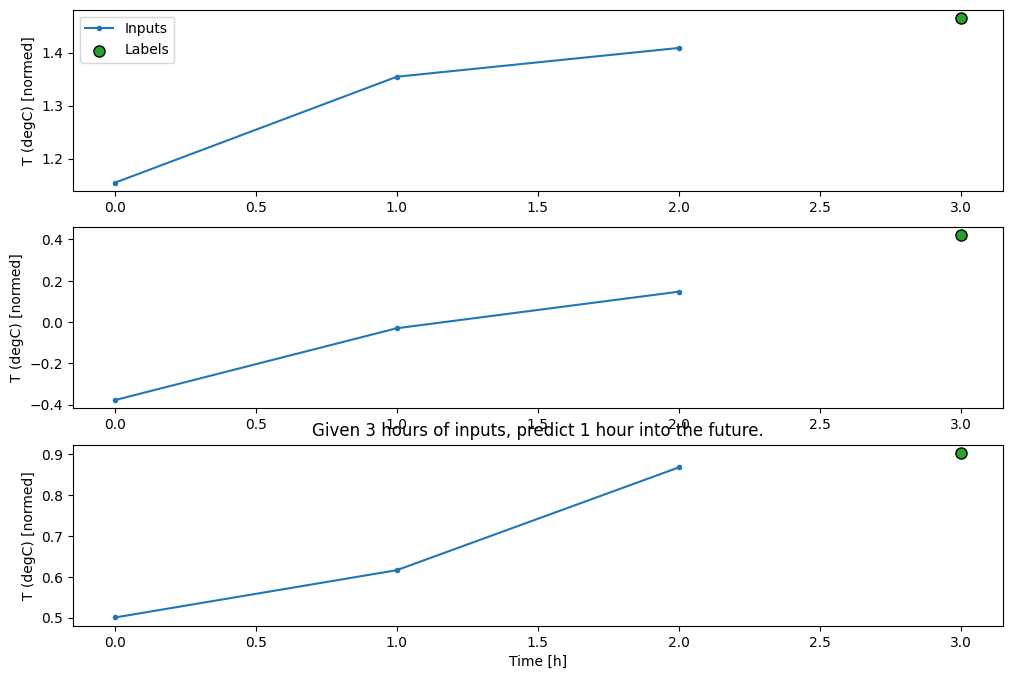

In [48]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

モデルの最初のレイヤーとして `tf.keras.layers.Flatten` を追加することで、複数入力ステップウィンドウで `dense` モデルをトレーニングすることができます。

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 37s - loss: 0.0078 - mean_absolute_error: 0.0629

 25/438 [>.............................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0607 

 53/438 [==>...........................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0609

 80/438 [====>.........................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0612

108/438 [======>.......................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0609

136/438 [========>.....................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0614

164/438 [==========>...................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0612

192/438 [============>.................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0609

219/438 [==============>...............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0608

246/438 [===============>..............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0611

274/438 [=================>............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0609

301/438 [===================>..........] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

330/438 [=====================>........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0609

359/438 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0608

387/438 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0609

415/438 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0611

438/438 [==============================] - 1s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0611


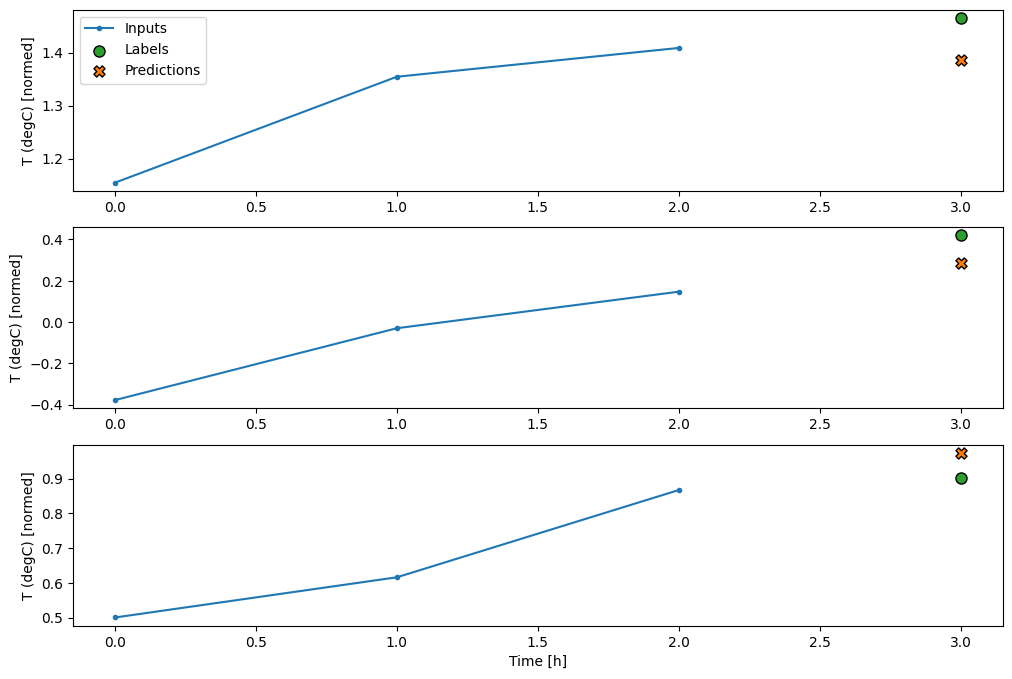

In [52]:
conv_window.plot(multi_step_dense)

このアプローチの主な欠点は、結果モデルを、まったくこの形状の入力ウィンドウでしか実行できないことです。 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


この問題は、次のセクションの畳み込みモデルで解決することができます。

### 畳み込みニューラルネットワーク

畳み込みレイヤー（`tf.keras.layers.Conv1D`）も、複数の時間ステップを各予測への入力として取ります。

以下に示すのは、`multi_step_dense` と**同じ**モデルを畳み込みで書き直したものです。

次の変更箇所に注意してください。

- `tf.keras.layers.Flatten` と最初の `tf.keras.layers.Dense` は `tf.keras.layers.Conv1D` に置き換えられています。
- 畳み込みが出力に time 軸を維持するため、`tf.keras.layers.Reshape` は不要となっています。

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

これをサンプルバッチで実行し、モデルが期待される形状の出力を生成することを確認します。

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


`conv_window` でトレーニングして評価すると、`multi_step_dense` モデルと似たようなパフォーマンスが得られます。

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 37s - loss: 0.0063 - mean_absolute_error: 0.0573

 21/438 [>.............................] - ETA: 1s - loss: 0.0061 - mean_absolute_error: 0.0584 

 43/438 [=>............................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0591

 64/438 [===>..........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0589

 85/438 [====>.........................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0583

107/438 [======>.......................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0577

129/438 [=======>......................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0584

151/438 [=========>....................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0583

173/438 [==========>...................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0582

195/438 [============>.................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0582

217/438 [=============>................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0581

239/438 [===============>..............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0580

261/438 [================>.............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0579

284/438 [==================>...........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0582

305/438 [===================>..........] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0584

326/438 [=====================>........] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0583

347/438 [======================>.......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0581

368/438 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0582

388/438 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0582

409/438 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0583

430/438 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0581

438/438 [==============================] - 1s 2ms/step - loss: 0.0065 - mean_absolute_error: 0.0580


この `conv_model` と `multi_step_dense` モデルの違いは、`conv_model` はあらゆる長さの入力に対して実行できるところにあります。畳み込みレイヤーは入力のスライドウィンドウに適用されます。

![シーケンスで畳み込みモデルを実行する](images/wide_conv_window.png)

より幅広い入力に対してこれを実行する場合、生成される出力も幅広くなります。

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


出力が入力よりも短いことに注意してください。トレーニングまたは描画がうまく機能するには、ラベルと、長さの同じ予測が必要です。そのため、いくつかの入力時間ステップを追加してワイドウィンドウを生成し、ラベルと予測の長さが一致するように、`WindowGenerator` を構築します。 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window


Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


これで、幅広いウィンドウでモデルの予測を描画できるようになりました。最初の予測の前に、3 つの入力時間ステップがあることに注目してください。各予測は、前の 3 つの時間ステップに基づきます。

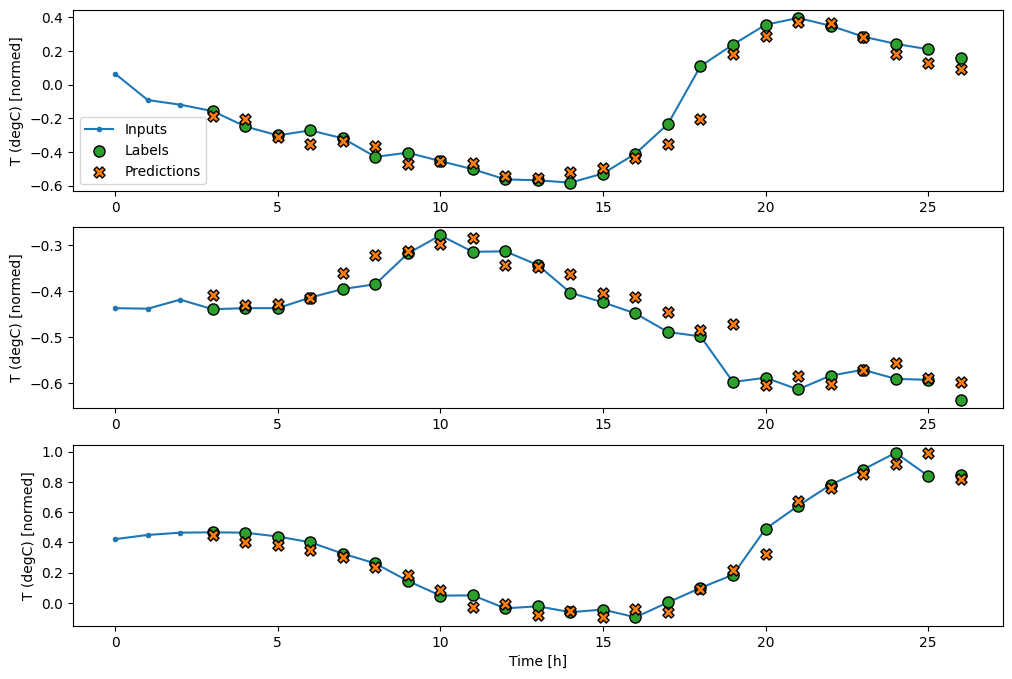

In [60]:
wide_conv_window.plot(conv_model)

### 回帰ニューラルネットワーク

回帰ニューラルネットワーク（RNN）は、時系列データに最適なニューラルネットワークの種類です。RNN は、ステップごとに時系列を処理し、時間ステップから時間ステップまでの内部状態を維持することができます。

[RNN によるテキスト生成](https://www.tensorflow.org/text/tutorials/text_generation)チュートリアルと [Keras による回帰ニューラルネットワーク（RNN）](https://www.tensorflow.org/guide/keras/rnn)ガイドでさらに学習することができます。

このチュートリアルでは、Long Short Term Memory（`tf.keras.layers.LSTM`）という RNN レイヤーを使用します。

`tf.keras.layers.LSTM` などのすべての Keras RNN レイヤーの重要なコンストラクタ引数は、`return_sequences` 引数です。この設定は、次の 2 つのいずれかの方法でレイヤーを構成することができます。

1. `False` である場合（デフォルト）、レイヤーは、最後の時間ステップの出力のみを返すため、単一の予測を立てる前に、内部状態をウォームアップする時間を得られます。

![ウォームアップして単一の予測を立てる LSTM](images/lstm_1_window.png)

1. `True` である場合、レイヤーは、各入力に対する出力を返し、次の項目に役立てることができます。
    - RNN レイヤーをスタックする。
    - 複数の時間ステップで同時にモデルをトレーニングする。

![時間ステップの後に予測を立てる LSTM](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

`return_sequences=True` の場合、24 時間のデータで一度にモデルをトレーニングすることができます。

注意: モデルのパフォーマンスとしては悲観的な見解になります。最初の時間ステップは前のステップにアクセスできないため、上記に示した単純な `linear` モデルと `dense` モデルとあまり変わりません。

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 38s - loss: 0.0061 - mean_absolute_error: 0.0529

 18/438 [>.............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0522 

 36/438 [=>............................] - ETA: 1s - loss: 0.0053 - mean_absolute_error: 0.0515

 54/438 [==>...........................] - ETA: 1s - loss: 0.0054 - mean_absolute_error: 0.0518

 72/438 [===>..........................] - ETA: 1s - loss: 0.0054 - mean_absolute_error: 0.0517

 91/438 [=====>........................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0518

110/438 [======>.......................] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0517

128/438 [=======>......................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0517

146/438 [=========>....................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0517

164/438 [==========>...................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0516

182/438 [===========>..................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

200/438 [============>.................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0515

218/438 [=============>................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0516

236/438 [===============>..............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0515

254/438 [================>.............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0516

272/438 [=================>............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0516

290/438 [==================>...........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0516

308/438 [====================>.........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0516

326/438 [=====================>........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0517

345/438 [======================>.......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0517

363/438 [=======================>......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0517

381/438 [=========================>....] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0517

399/438 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

417/438 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0518

435/438 [============================>.] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0518

438/438 [==============================] - 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0518


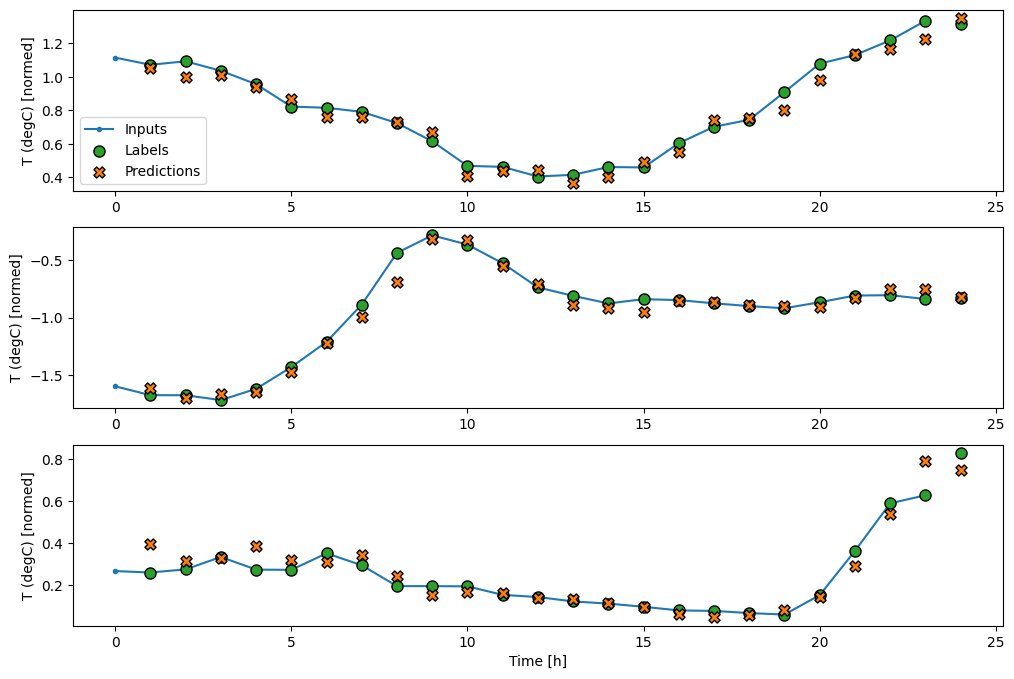

In [64]:
wide_window.plot(lstm_model)

### パフォーマンス

このデータセットでは、通常、各モデルは前のモデルよりわずかな改善が見られます。

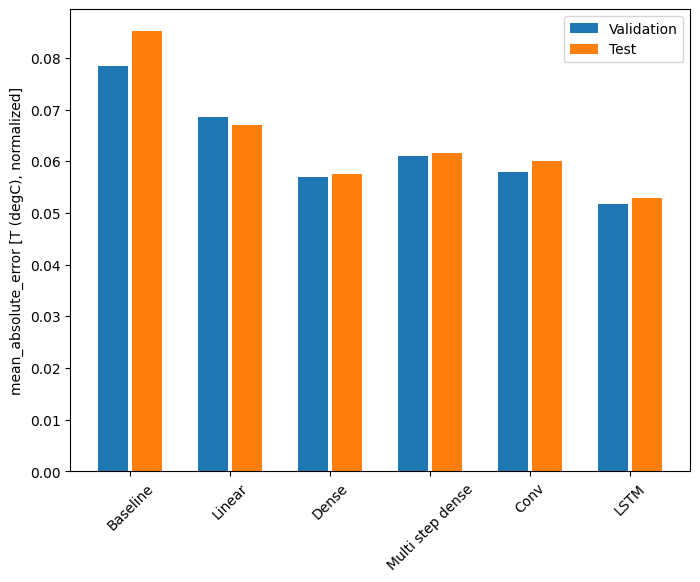

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0670
Dense       : 0.0575
Multi step dense: 0.0616
Conv        : 0.0601
LSTM        : 0.0529


### 複数出力モデル

モデルはこれまで、単一時間ステップに対して単一出力特徴量 `T (degC)` をすべて予測しました。

これらのモデルはすべて、出力レイヤーのユニット数を変更し、`labels`（`example_labels`）のすべての特徴量を含めるようにトレーニングウィンドウを調整するだけで、複数の特徴量を予測するように変換することができます。

In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


上記では、ラベルの `features` 軸に `1` ではなく、入力と同じ深度があることに注意してください。

#### 基準

ここでは同じ基準モデル（`Baseline`）を使用できますが、今回は、特定の `label_index` を選択する代わりにすべての特徴量を繰り返します。

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 1:04 - loss: 0.1117 - mean_absolute_error: 0.1729

 28/438 [>.............................] - ETA: 0s - loss: 0.0878 - mean_absolute_error: 0.1574  

 58/438 [==>...........................] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1584

 88/438 [=====>........................] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1589

119/438 [=======>......................] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1588

150/438 [=========>....................] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1588

181/438 [===========>..................] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1588

211/438 [=============>................] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1588

241/438 [===============>..............] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

270/438 [=================>............] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

299/438 [===================>..........] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

328/438 [=====================>........] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1587

358/438 [=======================>......] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1589

388/438 [=========================>....] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

418/438 [===========================>..] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 36s - loss: 0.0797 - mean_absolute_error: 0.1553

 21/439 [>.............................] - ETA: 1s - loss: 0.0653 - mean_absolute_error: 0.1313 

 41/439 [=>............................] - ETA: 1s - loss: 0.0669 - mean_absolute_error: 0.1323

 62/439 [===>..........................] - ETA: 0s - loss: 0.0669 - mean_absolute_error: 0.1326

 82/439 [====>.........................] - ETA: 0s - loss: 0.0667 - mean_absolute_error: 0.1330

102/439 [=====>........................] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1332

123/439 [=======>......................] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1330

144/439 [========>.....................] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1333

164/439 [==========>...................] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1333

185/439 [===========>..................] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1339

206/439 [=============>................] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1341

227/439 [==============>...............] - ETA: 0s - loss: 0.0694 - mean_absolute_error: 0.1342

248/439 [===============>..............] - ETA: 0s - loss: 0.0694 - mean_absolute_error: 0.1343

271/439 [=================>............] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1339

291/439 [==================>...........] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1340

312/439 [====================>.........] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1338

333/439 [=====================>........] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1336

354/439 [=======================>......] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1337

375/439 [========================>.....] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1340

395/439 [=========================>....] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.1343

415/439 [===========================>..] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.1344

436/439 [============================>.] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.1344

439/439 [==============================] - 1s 2ms/step - loss: 0.0692 - mean_absolute_error: 0.1344


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 37s - loss: 0.0702 - mean_absolute_error: 0.1272

 19/438 [>.............................] - ETA: 1s - loss: 0.0627 - mean_absolute_error: 0.1214 

 37/438 [=>............................] - ETA: 1s - loss: 0.0622 - mean_absolute_error: 0.1210

 55/438 [==>...........................] - ETA: 1s - loss: 0.0616 - mean_absolute_error: 0.1203

 74/438 [====>.........................] - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.1201

 92/438 [=====>........................] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1199

111/438 [======>.......................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1203

130/438 [=======>......................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1207

149/438 [=========>....................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1205

167/438 [==========>...................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1201

185/438 [===========>..................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1200

203/438 [============>.................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1201

221/438 [==============>...............] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1201

240/438 [===============>..............] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1201

258/438 [================>.............] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1200

276/438 [=================>............] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1200

294/438 [===================>..........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1201

313/438 [====================>.........] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1201

331/438 [=====================>........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1201

349/438 [======================>.......] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1201

368/438 [========================>.....] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1199

387/438 [=========================>....] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1198

406/438 [==========================>...] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1197

424/438 [============================>.] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1197

438/438 [==============================] - 1s 3ms/step - loss: 0.0611 - mean_absolute_error: 0.1197



CPU times: user 5min 52s, sys: 1min 14s, total: 7min 7s
Wall time: 2min 39s


<a id="residual"></a>

#### 高度: 残差接続

上述の `Baseline` モデルは、時間ステップ間でシーケンスが大幅に変化しない事実を利用しました。このチュートリアルでトレーニングされたモデルはこれまで、ランダムに初期化されてから、出力が前の時間ステップからわずかに変化することを学習する必要がありました。

初期化に注意を払うことで、この問題を回避することはできますが、これをモデル構造に構築する方がより単純です。

時系列の分析では、次の値を予測する代わりに、次の時間ステップで値がどのように変化するかを予測するモデルを構築するのが一般的です。同様に、ディープラーニングの「<a href="https://arxiv.org/abs/1512.03385" class="external">残差ネットワーク</a>」または「ResNet」は、各レイヤーがモデルの累積結果に追加されるアーキテクチャを指しています。

これが、変化は小さいものだという理解を活用する方法です。

![残差接続のあるモデル](images/residual.png)

基本的に、これによってモデルは `Baseline` に一致するように初期化されます。このタスクでは、モデルの収束を高速化することができ、わずかにパフォーマンスが向上されます。

このアプローチは、このチュートリアルで触れたあらゆるモデルと併用することができます。

ここでは、LSTM モデルに適用されています。最初の予測変化が小さく、残差接続より上回らないように、`tf.initializers.zeros` が使用されているところに注意してください。`zeros` は最後のレイヤーにだけ使用されているため、ここでは勾配の対称性が壊される懸念はありません。

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 37s - loss: 0.0649 - mean_absolute_error: 0.1218

 18/438 [>.............................] - ETA: 1s - loss: 0.0635 - mean_absolute_error: 0.1184 

 36/438 [=>............................] - ETA: 1s - loss: 0.0631 - mean_absolute_error: 0.1186

 54/438 [==>...........................] - ETA: 1s - loss: 0.0637 - mean_absolute_error: 0.1192

 72/438 [===>..........................] - ETA: 1s - loss: 0.0631 - mean_absolute_error: 0.1187

 90/438 [=====>........................] - ETA: 1s - loss: 0.0630 - mean_absolute_error: 0.1187

108/438 [======>.......................] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1182

126/438 [=======>......................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

144/438 [========>.....................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

162/438 [==========>...................] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1180

180/438 [===========>..................] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1180

198/438 [============>.................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1179

216/438 [=============>................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

235/438 [===============>..............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

254/438 [================>.............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1175

272/438 [=================>............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

290/438 [==================>...........] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1177

308/438 [====================>.........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

326/438 [=====================>........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

344/438 [======================>.......] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1177

362/438 [=======================>......] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1177

381/438 [=========================>....] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

399/438 [==========================>...] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

417/438 [===========================>..] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

436/438 [============================>.] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

438/438 [==============================] - 1s 3ms/step - loss: 0.0621 - mean_absolute_error: 0.1177



CPU times: user 1min 34s, sys: 19.1 s, total: 1min 53s
Wall time: 43.4 s


#### パフォーマンス

これらの複数出力モデルの全体的なパフォーマンスは、次のようになります。

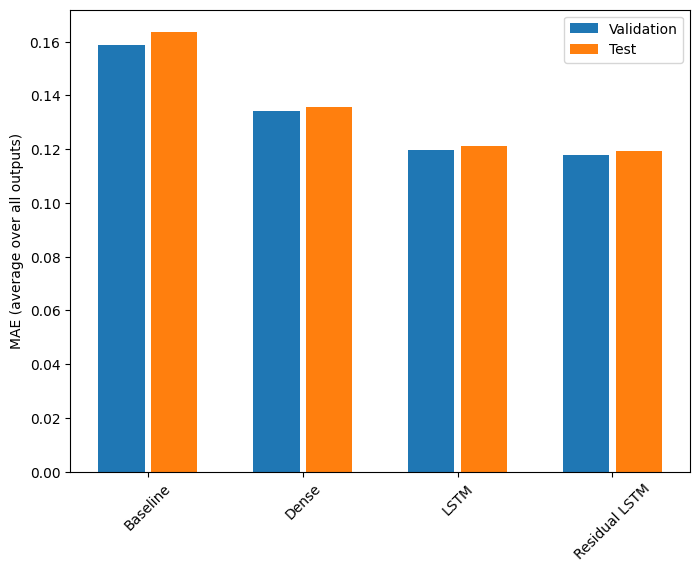

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1356
LSTM           : 0.1210
Residual LSTM  : 0.1192


上記のパフォーマンスは、すべてのモデル出力の平均です。

## 複数ステップのモデル

前のセクションの単一出力と複数出力はともに、1 時間先までの**単一時間ステップ予測**を行いました。

このセクションでは、これらのモデルを拡張し、**複数時間ステップ予測**を行います。

複数ステップ予測では、モデルは将来の値の範囲を予測できるように学習する必要があります。したがって、1 つの未来点を予測するだけの単一ステップモデルとは異なり、複数ステップモデルは、一連の未来の値を予測します。

これには大まかなアプローチが 2 つあります。

1. 時系列全体を一度に予測するシングルショット予測
2. モデルは単一ステップ予測を行い、その出力が入力としてフィードされる、自動回帰予測

このセクションでは、すべてのモデルは、**全出力時間ステップのすべての特徴量**を予測します。


複数ステップモデルでは、トレーニングデータは時間ごとのサンプルで構成されますが、ここでは、過去 24 時間のデータがある場合に、モデルは 24 時間先を予測するように学習します。

次は、データセットからこれらのスライスを生成する `Window` オブジェクトです。

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

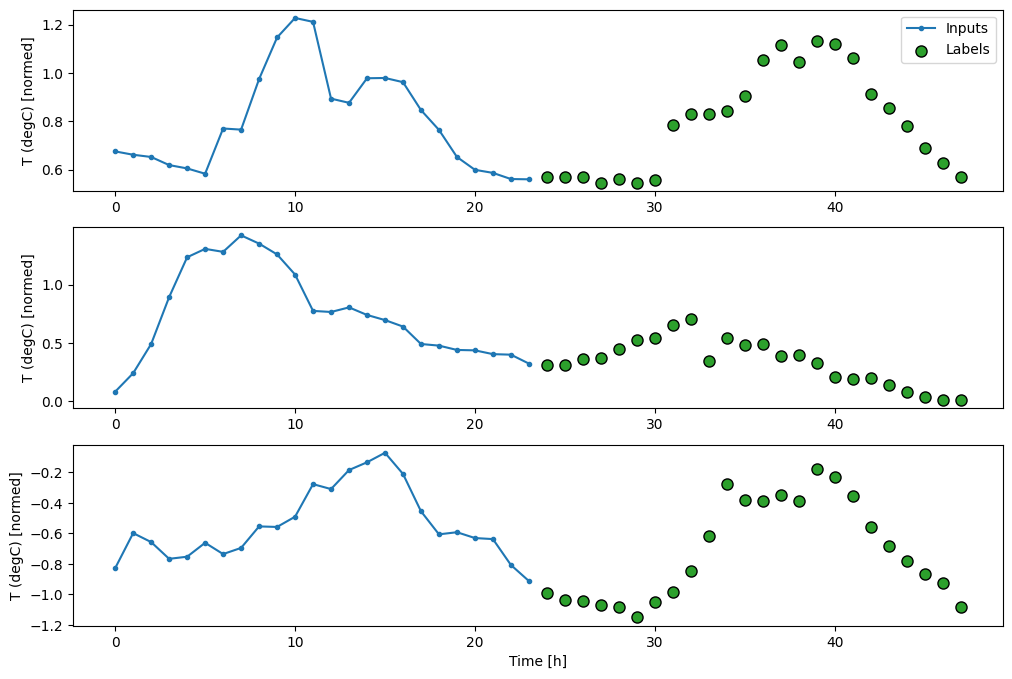

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### 基準

このタスクの単純な基準は、最後の入力時間ステップを必要な出力時間ステップ数、繰り返すことです。

![各出力ステップごとに最後の入力を繰り返す](images/multistep_last.png)

  1/437 [..............................] - ETA: 1:15 - loss: 0.6322 - mean_absolute_error: 0.4858

 29/437 [>.............................] - ETA: 0s - loss: 0.6220 - mean_absolute_error: 0.4990  

 58/437 [==>...........................] - ETA: 0s - loss: 0.6168 - mean_absolute_error: 0.4967

 86/437 [====>.........................] - ETA: 0s - loss: 0.6156 - mean_absolute_error: 0.4962

114/437 [======>.......................] - ETA: 0s - loss: 0.6190 - mean_absolute_error: 0.4977

142/437 [========>.....................] - ETA: 0s - loss: 0.6193 - mean_absolute_error: 0.4970

170/437 [==========>...................] - ETA: 0s - loss: 0.6221 - mean_absolute_error: 0.4977

199/437 [============>.................] - ETA: 0s - loss: 0.6238 - mean_absolute_error: 0.4989

228/437 [==============>...............] - ETA: 0s - loss: 0.6244 - mean_absolute_error: 0.4988

257/437 [================>.............] - ETA: 0s - loss: 0.6262 - mean_absolute_error: 0.4998

286/437 [==================>...........] - ETA: 0s - loss: 0.6273 - mean_absolute_error: 0.5003

315/437 [====================>.........] - ETA: 0s - loss: 0.6266 - mean_absolute_error: 0.5000

346/437 [======================>.......] - ETA: 0s - loss: 0.6279 - mean_absolute_error: 0.5006

376/437 [========================>.....] - ETA: 0s - loss: 0.6282 - mean_absolute_error: 0.5007

406/437 [==========================>...] - ETA: 0s - loss: 0.6289 - mean_absolute_error: 0.5009

436/437 [============================>.] - ETA: 0s - loss: 0.6286 - mean_absolute_error: 0.5007

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


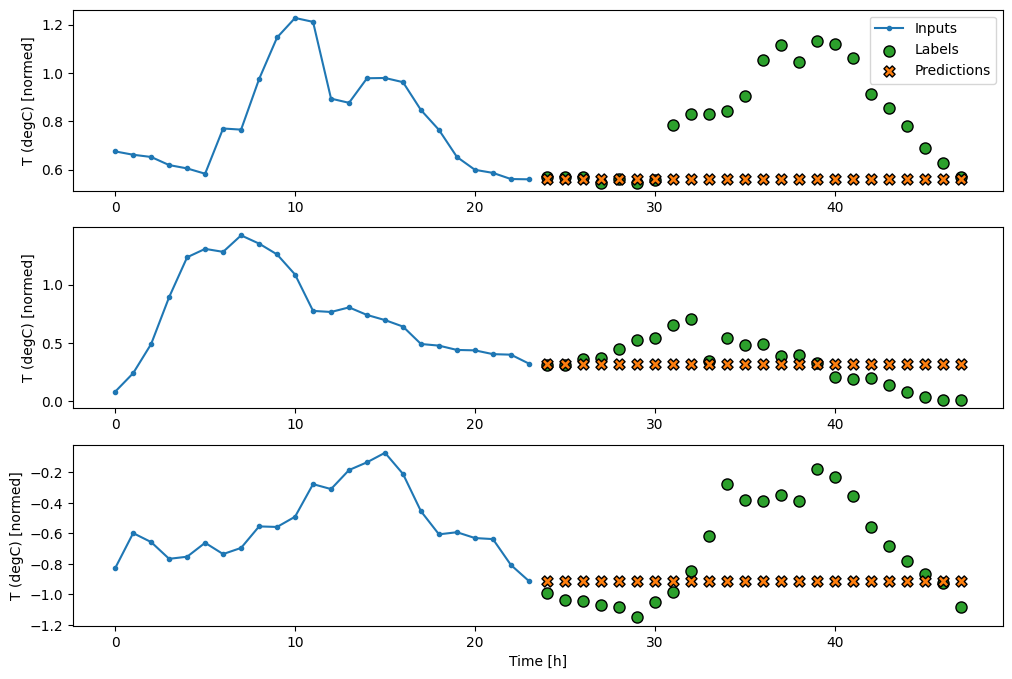

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

このタスクは、24 時間の履歴がある場合に 24 時間を予測するため、もう 1 つの単純なアプローチとして、翌日が同様であることを仮定し、前日を繰り返すことができます。

![前日を繰り返す](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 1:09 - loss: 0.3822 - mean_absolute_error: 0.3827

 30/437 [=>............................] - ETA: 0s - loss: 0.4185 - mean_absolute_error: 0.3926  

 59/437 [===>..........................] - ETA: 0s - loss: 0.4308 - mean_absolute_error: 0.3979

 88/437 [=====>........................] - ETA: 0s - loss: 0.4360 - mean_absolute_error: 0.3991

118/437 [=======>......................] - ETA: 0s - loss: 0.4356 - mean_absolute_error: 0.3997

147/437 [=========>....................] - ETA: 0s - loss: 0.4323 - mean_absolute_error: 0.3980

175/437 [===========>..................] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.3963

205/437 [=============>................] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.3964

233/437 [==============>...............] - ETA: 0s - loss: 0.4257 - mean_absolute_error: 0.3956

262/437 [================>.............] - ETA: 0s - loss: 0.4260 - mean_absolute_error: 0.3956

292/437 [===================>..........] - ETA: 0s - loss: 0.4253 - mean_absolute_error: 0.3952

323/437 [=====================>........] - ETA: 0s - loss: 0.4252 - mean_absolute_error: 0.3951

353/437 [=======================>......] - ETA: 0s - loss: 0.4266 - mean_absolute_error: 0.3956

383/437 [=========================>....] - ETA: 0s - loss: 0.4277 - mean_absolute_error: 0.3961

413/437 [===========================>..] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3958

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


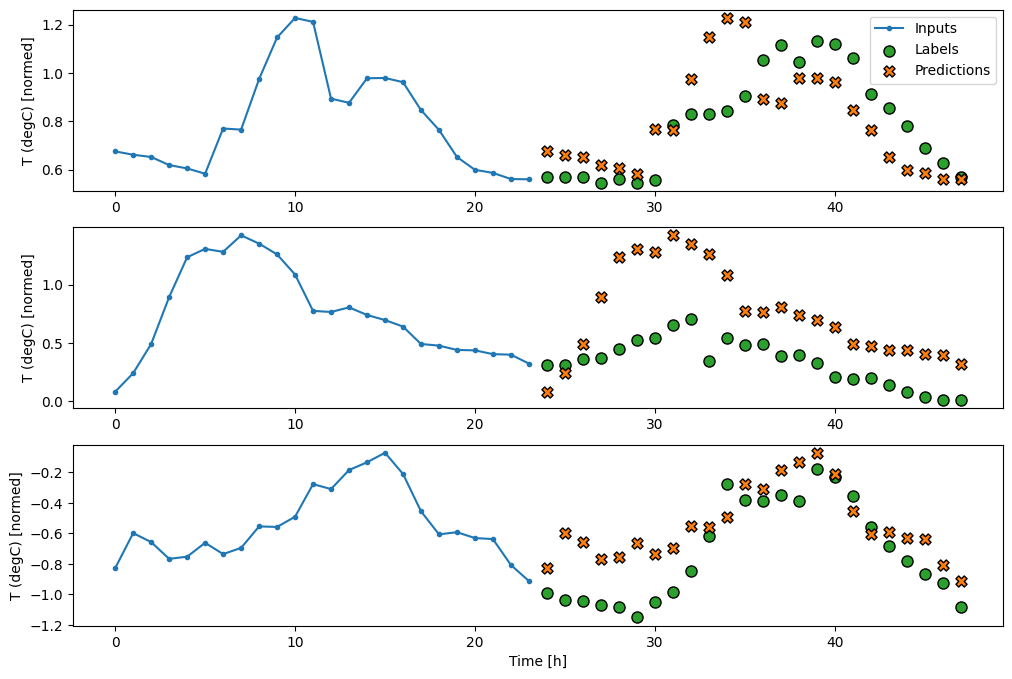

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### シングルショットモデル

この問題の高レベルなアプローチには、モデルがシーケンス全体の予測を単一のステップで行う「シングルショット」モデルがあります。

これは、`OUT_STEPS*features` 出力ユニットを使って `tf.keras.layers.Dense` として効率的に実装できます。このモデルには、出力の形状を必要な `(OUTPUT_STEPS, features)` に設定し直すことだけが必要です。

#### 線形

最後の時間ステップに基づく単純な線形モデルは、いずれの基準よりも優れていますが、パワーに劣ります。モデルは、線形投影の単一入力時間ステップから、`OUTPUT_STEPS` 時間ステップを予測する必要があります。おそらく主に時間帯と時期に基づいて、低次元スライスの行動のみをキャプチャできます。

![最後の時間ステップからのすべての時間ステップを予測する](images/multistep_dense.png)

  1/437 [..............................] - ETA: 36s - loss: 0.2190 - mean_absolute_error: 0.2912

 25/437 [>.............................] - ETA: 0s - loss: 0.2521 - mean_absolute_error: 0.3029 

 50/437 [==>...........................] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3055

 75/437 [====>.........................] - ETA: 0s - loss: 0.2548 - mean_absolute_error: 0.3047

100/437 [=====>........................] - ETA: 0s - loss: 0.2533 - mean_absolute_error: 0.3041

125/437 [=======>......................] - ETA: 0s - loss: 0.2557 - mean_absolute_error: 0.3054

150/437 [=========>....................] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3055

175/437 [===========>..................] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3054

200/437 [============>.................] - ETA: 0s - loss: 0.2567 - mean_absolute_error: 0.3056

224/437 [==============>...............] - ETA: 0s - loss: 0.2574 - mean_absolute_error: 0.3061

249/437 [================>.............] - ETA: 0s - loss: 0.2569 - mean_absolute_error: 0.3055

274/437 [=================>............] - ETA: 0s - loss: 0.2567 - mean_absolute_error: 0.3053

300/437 [===================>..........] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3049

326/437 [=====================>........] - ETA: 0s - loss: 0.2556 - mean_absolute_error: 0.3044

351/437 [=======================>......] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3049

376/437 [========================>.....] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3049

400/437 [==========================>...] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3050

424/437 [============================>.] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3049

437/437 [==============================] - 1s 2ms/step - loss: 0.2559 - mean_absolute_error: 0.3048


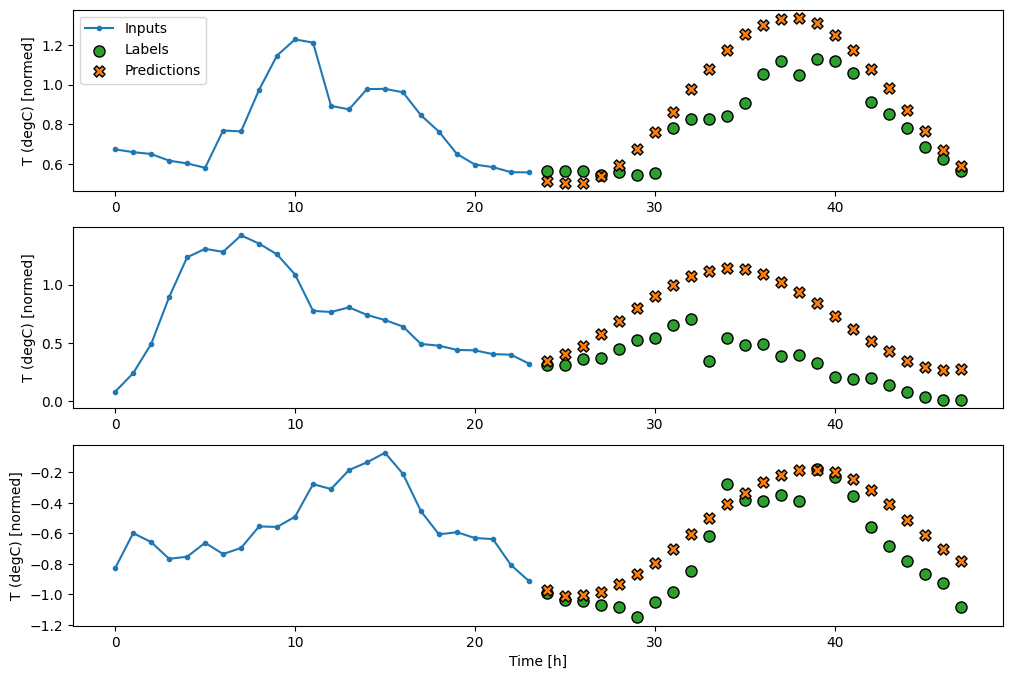

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

入力と出力の間に `tf.keras.layers.Dense` を追加すると、線形モデルにパワーが追加されますが、依然として、単一入力時間ステップのみに基づいたままとなります。

  1/437 [..............................] - ETA: 36s - loss: 0.1966 - mean_absolute_error: 0.2754

 23/437 [>.............................] - ETA: 0s - loss: 0.2102 - mean_absolute_error: 0.2785 

 46/437 [==>...........................] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2796

 69/437 [===>..........................] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2808

 90/437 [=====>........................] - ETA: 0s - loss: 0.2165 - mean_absolute_error: 0.2800

112/437 [======>.......................] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2813

134/437 [========>.....................] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2804

156/437 [=========>....................] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2813

179/437 [===========>..................] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2821

201/437 [============>.................] - ETA: 0s - loss: 0.2193 - mean_absolute_error: 0.2819

223/437 [==============>...............] - ETA: 0s - loss: 0.2198 - mean_absolute_error: 0.2822

245/437 [===============>..............] - ETA: 0s - loss: 0.2201 - mean_absolute_error: 0.2823

267/437 [=================>............] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2818

289/437 [==================>...........] - ETA: 0s - loss: 0.2193 - mean_absolute_error: 0.2819

311/437 [====================>.........] - ETA: 0s - loss: 0.2197 - mean_absolute_error: 0.2822

333/437 [=====================>........] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2822

355/437 [=======================>......] - ETA: 0s - loss: 0.2201 - mean_absolute_error: 0.2823

377/437 [========================>.....] - ETA: 0s - loss: 0.2201 - mean_absolute_error: 0.2823

399/437 [==========================>...] - ETA: 0s - loss: 0.2204 - mean_absolute_error: 0.2826

421/437 [===========================>..] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.2826

437/437 [==============================] - 1s 2ms/step - loss: 0.2201 - mean_absolute_error: 0.2824


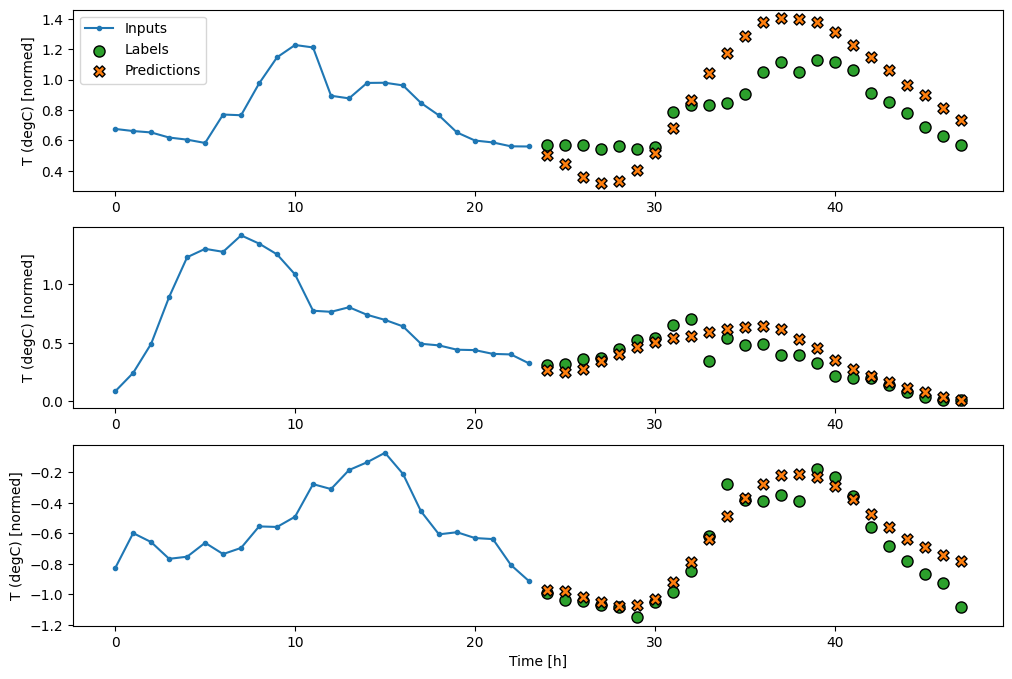

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

畳み込みモデルは、固定幅の履歴に基づく予測を行います。このため、時間の経過とともに変化する様子を確認できるため、密なモデルよりも優れたパフォーマンスが得られる可能性があります。

![畳み込みモデルは、時間の経過とともに変化する様子を確認する](images/multistep_conv.png)

  1/437 [..............................] - ETA: 37s - loss: 0.2326 - mean_absolute_error: 0.2773

 24/437 [>.............................] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2820 

 47/437 [==>...........................] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2814

 70/437 [===>..........................] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2822

 93/437 [=====>........................] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2832

116/437 [======>.......................] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2824

140/437 [========>.....................] - ETA: 0s - loss: 0.2165 - mean_absolute_error: 0.2827

164/437 [==========>...................] - ETA: 0s - loss: 0.2155 - mean_absolute_error: 0.2819

188/437 [===========>..................] - ETA: 0s - loss: 0.2161 - mean_absolute_error: 0.2823

212/437 [=============>................] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2825

236/437 [===============>..............] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2826

259/437 [================>.............] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2827

283/437 [==================>...........] - ETA: 0s - loss: 0.2174 - mean_absolute_error: 0.2826

307/437 [====================>.........] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2823

330/437 [=====================>........] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2822

354/437 [=======================>......] - ETA: 0s - loss: 0.2165 - mean_absolute_error: 0.2825

377/437 [========================>.....] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2826

401/437 [==========================>...] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2823

425/437 [============================>.] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2822

437/437 [==============================] - 1s 2ms/step - loss: 0.2160 - mean_absolute_error: 0.2820


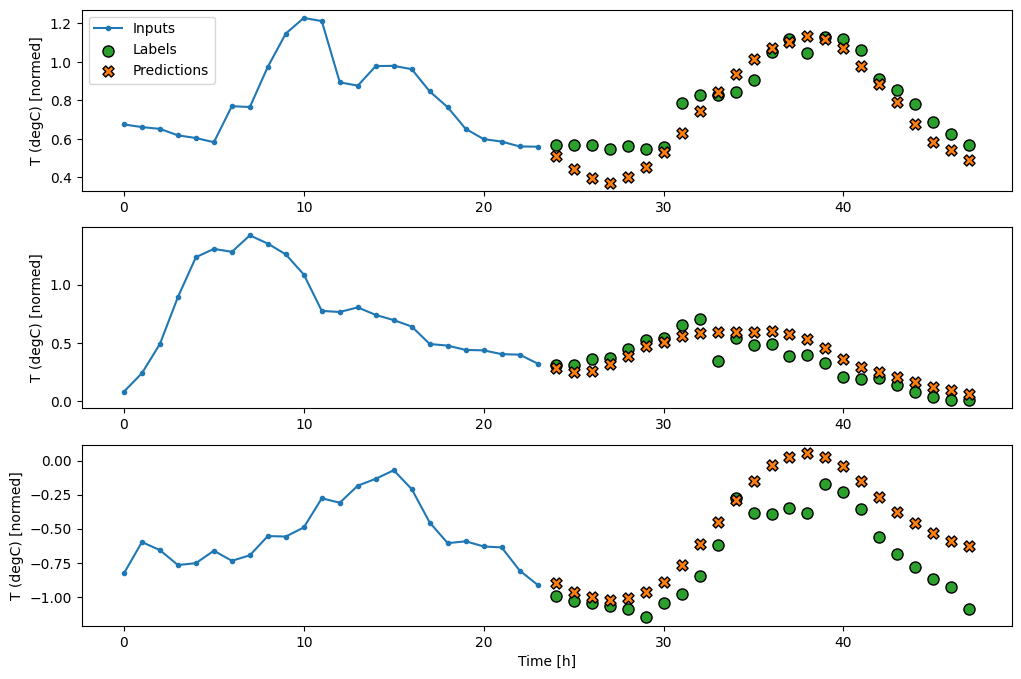

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

回帰モデルは、入力の長い履歴がモデルが行おうとしている予測に関連している場合に、それを使用して学習できます。ここでは、内部状態を 24 時間累積した上で、次の 24 時間の単一の予測が行われます。

このシングルショット形式では、LSTM は、最後の時間ステップの出力のみを生成する必要があるため、`tf.keras.layers.LSTM` で `return_sequences=False` に設定します。

![LSTM は入力ウィンドウ全体の状態を蓄積し、次の 24 時間について 1 つの予測を行う](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 36s - loss: 0.2466 - mean_absolute_error: 0.3059

 19/437 [>.............................] - ETA: 1s - loss: 0.2214 - mean_absolute_error: 0.2872 

 39/437 [=>............................] - ETA: 1s - loss: 0.2151 - mean_absolute_error: 0.2836

 60/437 [===>..........................] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2852

 80/437 [====>.........................] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2845

101/437 [=====>........................] - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.2842

121/437 [=======>......................] - ETA: 0s - loss: 0.2127 - mean_absolute_error: 0.2839

141/437 [========>.....................] - ETA: 0s - loss: 0.2125 - mean_absolute_error: 0.2839

161/437 [==========>...................] - ETA: 0s - loss: 0.2124 - mean_absolute_error: 0.2836

181/437 [===========>..................] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.2839

201/437 [============>.................] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2839

221/437 [==============>...............] - ETA: 0s - loss: 0.2126 - mean_absolute_error: 0.2837

241/437 [===============>..............] - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.2836

261/437 [================>.............] - ETA: 0s - loss: 0.2122 - mean_absolute_error: 0.2835

281/437 [==================>...........] - ETA: 0s - loss: 0.2124 - mean_absolute_error: 0.2836

301/437 [===================>..........] - ETA: 0s - loss: 0.2124 - mean_absolute_error: 0.2835

321/437 [=====================>........] - ETA: 0s - loss: 0.2125 - mean_absolute_error: 0.2836

341/437 [======================>.......] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2842

361/437 [=======================>......] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2842

381/437 [=========================>....] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2841

402/437 [==========================>...] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2841

423/437 [============================>.] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2842

437/437 [==============================] - 1s 3ms/step - loss: 0.2139 - mean_absolute_error: 0.2842


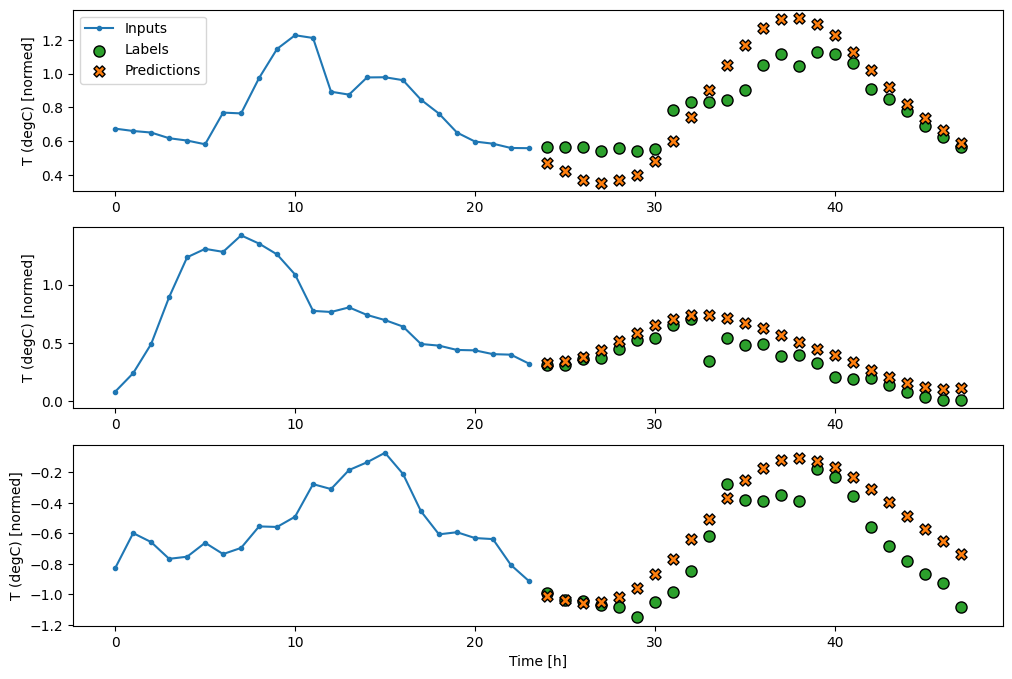

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### 高度: 自動回帰モデル

上記のモデルはすべて、単一のステップで、出力シーケンス全体を予測します。

一部のケースでは、モデルがこの予測を個別の時間ステップに分解することが役立つ可能性があります。その上で、各モデルの出力を各ステップでそれ自体にフィードし、従来の「<a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>」のように、前の予測で条件づけられた予測を立てることができます。

このスタイルのモデルには、長さの異なる出力を生成するようにセットアップできるという明確なメリットがあります。

このチュートリアルの前半でトレーニングされた単一ステップ複数出力モデルを使って、自動回帰フィードバックループで実行することもできますが、ここでは、それを行うように明示的にトレーニングされたモデルを構築することに焦点を当てることにします。

![モデルの出力を入力にフィードバックする](images/multistep_autoregressive.png)

#### RNN

このチュートリアルでは自動回帰 RNN モデルのみを構築しますが、このパターンは、単一時間ステップを出力するために設計されたモデルに適用することができます。

モデルには、前の単一ステップの LSTM モデルと同じ基本形式があります。`LSTM` レイヤーの出力をモデルの予測に変換する、`tf.keras.layers.Dense` が続く `tf.keras.layers.LSTM` レイヤーです。

`tf.keras.layers.LSTM` は、状態とシーケンス結果を管理するより高位の `tf.keras.layers.RNN` にラッピングされた `tf.keras.layers.LSTMCell` です（詳細は、[Keras による回帰ニューラルネットワーク（RNN）](https://www.tensorflow.org/guide/keras/rnn)ガイドをご覧ください。

この場合、モデルは、より低レベルの単一時間ステップインターフェースに直接 `tf.keras.layers.LSTMCell` を使用するように、各ステップの入力を手動で管理する必要があります。

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

このモデルが必要とする最初のメソッドは、入力に応じて内部状態を初期化する `warmup` メソッドです。トレーニングされると、この状態は入力履歴の関連する部分をキャプチャするようになります。これは、上記の単一ステップ `LSTM` モデルと同等です。

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

このメソッドは、単一の時間ステップ予測と `LSTM` の内部状態を返します。

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

`RNN` の状態と初期の予測によって、各ステップの予測を入力としてフィードし直すモデルのイテレーションを続行できるようになりました。

出力予測を収集する最も単純なアプローチは、Python リストと、ループ後に `tf.stack` を使用する方法です。

注意: このような Python リストのスタックは、Eager execution、トレーニングの `Model.compile(..., run_eagerly=True)` の使用、または固定長出力によってのみ機能します。動的出力長については、Python リストの代わりに `tf.TensorArray`、Python `range` の代わりに `tf.range` を使用する必要があります。

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

サンプル入力にこのモデルをテスト実行します。

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


次に、モデルをトレーニングします。

  1/437 [..............................] - ETA: 39s - loss: 0.2162 - mean_absolute_error: 0.3019

  7/437 [..............................] - ETA: 3s - loss: 0.2202 - mean_absolute_error: 0.2994 

 14/437 [..............................] - ETA: 3s - loss: 0.2177 - mean_absolute_error: 0.2981

 21/437 [>.............................] - ETA: 3s - loss: 0.2274 - mean_absolute_error: 0.3030

 28/437 [>.............................] - ETA: 3s - loss: 0.2223 - mean_absolute_error: 0.2991

 35/437 [=>............................] - ETA: 3s - loss: 0.2229 - mean_absolute_error: 0.2995

 42/437 [=>............................] - ETA: 3s - loss: 0.2257 - mean_absolute_error: 0.3014

 49/437 [==>...........................] - ETA: 2s - loss: 0.2233 - mean_absolute_error: 0.3000

 56/437 [==>...........................] - ETA: 2s - loss: 0.2204 - mean_absolute_error: 0.2986

 63/437 [===>..........................] - ETA: 2s - loss: 0.2221 - mean_absolute_error: 0.2988

 70/437 [===>..........................] - ETA: 2s - loss: 0.2226 - mean_absolute_error: 0.2990

 77/437 [====>.........................] - ETA: 2s - loss: 0.2203 - mean_absolute_error: 0.2981

 84/437 [====>.........................] - ETA: 2s - loss: 0.2199 - mean_absolute_error: 0.2979

 91/437 [=====>........................] - ETA: 2s - loss: 0.2195 - mean_absolute_error: 0.2979

 98/437 [=====>........................] - ETA: 2s - loss: 0.2189 - mean_absolute_error: 0.2975

105/437 [======>.......................] - ETA: 2s - loss: 0.2206 - mean_absolute_error: 0.2985

112/437 [======>.......................] - ETA: 2s - loss: 0.2191 - mean_absolute_error: 0.2973

119/437 [=======>......................] - ETA: 2s - loss: 0.2188 - mean_absolute_error: 0.2970

126/437 [=======>......................] - ETA: 2s - loss: 0.2195 - mean_absolute_error: 0.2974

133/437 [========>.....................] - ETA: 2s - loss: 0.2195 - mean_absolute_error: 0.2977

140/437 [========>.....................] - ETA: 2s - loss: 0.2199 - mean_absolute_error: 0.2979

147/437 [=========>....................] - ETA: 2s - loss: 0.2203 - mean_absolute_error: 0.2980

154/437 [=========>....................] - ETA: 2s - loss: 0.2208 - mean_absolute_error: 0.2984

161/437 [==========>...................] - ETA: 2s - loss: 0.2202 - mean_absolute_error: 0.2980

168/437 [==========>...................] - ETA: 2s - loss: 0.2199 - mean_absolute_error: 0.2978

175/437 [===========>..................] - ETA: 2s - loss: 0.2202 - mean_absolute_error: 0.2981

182/437 [===========>..................] - ETA: 1s - loss: 0.2205 - mean_absolute_error: 0.2983

189/437 [===========>..................] - ETA: 1s - loss: 0.2210 - mean_absolute_error: 0.2986

196/437 [============>.................] - ETA: 1s - loss: 0.2215 - mean_absolute_error: 0.2988

203/437 [============>.................] - ETA: 1s - loss: 0.2214 - mean_absolute_error: 0.2988

210/437 [=============>................] - ETA: 1s - loss: 0.2214 - mean_absolute_error: 0.2987

217/437 [=============>................] - ETA: 1s - loss: 0.2212 - mean_absolute_error: 0.2985

224/437 [==============>...............] - ETA: 1s - loss: 0.2210 - mean_absolute_error: 0.2983

231/437 [==============>...............] - ETA: 1s - loss: 0.2212 - mean_absolute_error: 0.2985

238/437 [===============>..............] - ETA: 1s - loss: 0.2216 - mean_absolute_error: 0.2988

245/437 [===============>..............] - ETA: 1s - loss: 0.2215 - mean_absolute_error: 0.2988

252/437 [================>.............] - ETA: 1s - loss: 0.2213 - mean_absolute_error: 0.2986

259/437 [================>.............] - ETA: 1s - loss: 0.2213 - mean_absolute_error: 0.2986

266/437 [=================>............] - ETA: 1s - loss: 0.2213 - mean_absolute_error: 0.2986

273/437 [=================>............] - ETA: 1s - loss: 0.2210 - mean_absolute_error: 0.2985

280/437 [==================>...........] - ETA: 1s - loss: 0.2213 - mean_absolute_error: 0.2987

287/437 [==================>...........] - ETA: 1s - loss: 0.2212 - mean_absolute_error: 0.2986

294/437 [===================>..........] - ETA: 1s - loss: 0.2213 - mean_absolute_error: 0.2986

301/437 [===================>..........] - ETA: 1s - loss: 0.2215 - mean_absolute_error: 0.2987

308/437 [====================>.........] - ETA: 0s - loss: 0.2215 - mean_absolute_error: 0.2989

315/437 [====================>.........] - ETA: 0s - loss: 0.2217 - mean_absolute_error: 0.2990

322/437 [=====================>........] - ETA: 0s - loss: 0.2220 - mean_absolute_error: 0.2992

329/437 [=====================>........] - ETA: 0s - loss: 0.2216 - mean_absolute_error: 0.2990

336/437 [======================>.......] - ETA: 0s - loss: 0.2213 - mean_absolute_error: 0.2988

343/437 [======================>.......] - ETA: 0s - loss: 0.2214 - mean_absolute_error: 0.2989

350/437 [=======================>......] - ETA: 0s - loss: 0.2213 - mean_absolute_error: 0.2989

357/437 [=======================>......] - ETA: 0s - loss: 0.2210 - mean_absolute_error: 0.2988

364/437 [=======================>......] - ETA: 0s - loss: 0.2214 - mean_absolute_error: 0.2990

371/437 [========================>.....] - ETA: 0s - loss: 0.2214 - mean_absolute_error: 0.2990

378/437 [========================>.....] - ETA: 0s - loss: 0.2212 - mean_absolute_error: 0.2990

385/437 [=========================>....] - ETA: 0s - loss: 0.2213 - mean_absolute_error: 0.2990

392/437 [=========================>....] - ETA: 0s - loss: 0.2215 - mean_absolute_error: 0.2990

399/437 [==========================>...] - ETA: 0s - loss: 0.2220 - mean_absolute_error: 0.2992

406/437 [==========================>...] - ETA: 0s - loss: 0.2221 - mean_absolute_error: 0.2992

413/437 [===========================>..] - ETA: 0s - loss: 0.2223 - mean_absolute_error: 0.2993

420/437 [===========================>..] - ETA: 0s - loss: 0.2221 - mean_absolute_error: 0.2992

427/437 [============================>.] - ETA: 0s - loss: 0.2222 - mean_absolute_error: 0.2993

434/437 [============================>.] - ETA: 0s - loss: 0.2222 - mean_absolute_error: 0.2993

437/437 [==============================] - 3s 8ms/step - loss: 0.2224 - mean_absolute_error: 0.2994


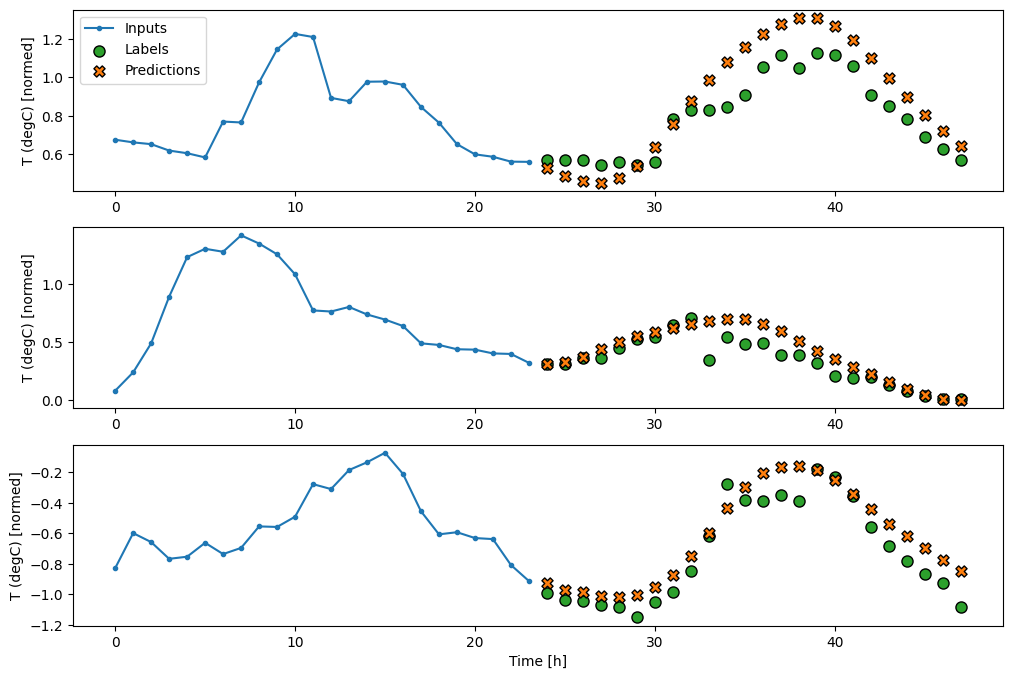

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### パフォーマンス

この問題では、モデルの複雑さの関数として、戻り値が明確に小さくなっています。

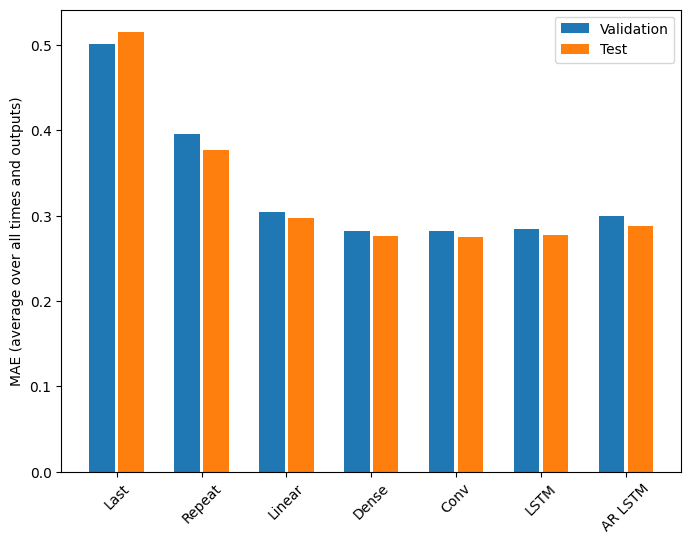

In [91]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

このチュートリアルの前半で説明した複数出力モデルのメトリックから、すべての出力特徴量全体で平均化されていることがわかります。これらのパフォーマンスは似ていますが、出力時間ステップ間でも平均化されています。 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2978
Dense   : 0.2765
Conv    : 0.2752
LSTM    : 0.2775
AR LSTM : 0.2884


密なモデルから畳み込みと回帰モデルに移行したことで得られたのは、あったとしてもわずか数パーセント程度で、自動回帰モデルのパフォーマンスは明らかに低いものでした。そのため、こういったより複雑なアプローチは**この**問題に使用するほどの価値はありませんでしたが、試さなければ、このような結果も知るすべはありません。これらのモデルは、**他の**問題には役立つものかもしれません。

## 次のステップ

このチュートリアルでは、TensorFlow を使った時系列予測を簡単に紹介しました。

さらに学習するには、以下をご覧ください。

- 「<a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>」（第 2 版）の第 15 章
- 「<a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>」の第 6 章
- 「<a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>」のレッスン 8、および<a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">実践ノートブック</a>

また、TensorFlow では、<a href="https://otexts.com/fpp2/index.html" class="external">古典的な時系列モデル</a>を実装することもできます。このチュートリアルは、TensorFlow の組み込み機能に焦点が当てられています。
